In [1]:
import sys
sys.path.append("../")
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import math
from utils.toy_dataset import GaussianMixture
from torch.optim.lr_scheduler import CosineAnnealingLR

## Parameter of the distribution

/media/data/conda/vboutin/envs/pytorch2/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


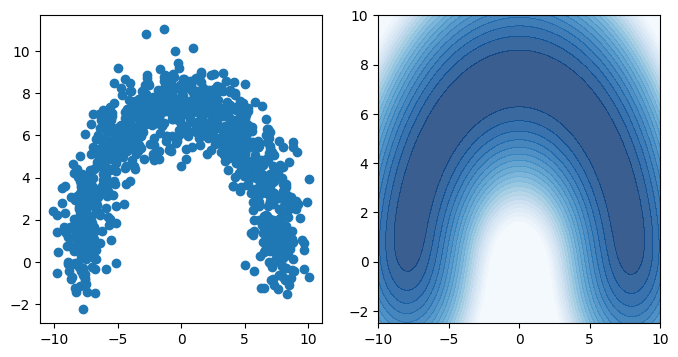

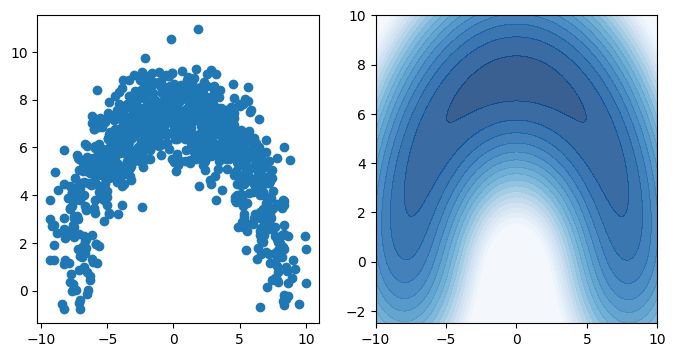

In [2]:
NB_GAUSSIANS = 200
RADIUS = 8
DEVICE = "cuda:1"
mean_ = (torch.linspace(0, 180, NB_GAUSSIANS + 1)[0:-1] * math.pi / 180)
MEAN = RADIUS * torch.stack([torch.cos(mean_), torch.sin(mean_)], dim=1) - torch.tensor([0.0,0.5])
COVAR = torch.tensor([[1.0, 0], [0, 1.0]]).unsqueeze(0).repeat(len(MEAN), 1, 1)

x_p, y_p = torch.meshgrid(torch.linspace(-10, 10, 100), torch.linspace(-2.5, 10, 62), indexing='xy')
pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)

## Gaussian Mixture Uniformly distributed
weight_1 = (torch.ones(NB_GAUSSIANS) / NB_GAUSSIANS)
mixture_1 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=weight_1).to(DEVICE)


fig, ax = plt.subplots(1, 2, figsize=(2*4, 4), dpi=100)
sample_1 = mixture_1.sample(1000).cpu().detach()
#offset_1 = torch.tensor([0.0, 4.0])
#mult_1  = torch.tensor([10.0, 6.0])

energy_landscape_1 = mixture_1.energy(pos)

#sample_1_t = (sample_1-offset_1)/mult_1

mixture_sampling = GaussianMixture(center_data=MEAN, covar=COVAR*5, weight=weight_1).to(DEVICE)
ax[0].scatter(sample_1[:,0],sample_1[:,1])
im = ax[1].contourf(x_p, y_p, energy_landscape_1.view(62, 100).detach().cpu(), 20,
                        cmap='Blues_r',
                        alpha=0.8,
                        zorder=0,
                        levels=20)


plt.show()

## Gaussian Mixture non Uniformly distributed
linspace = torch.cat([torch.linspace(1, 30, 90),torch.ones(11)*30])
weight_2 = torch.cat([linspace, linspace[1:-1].flip(dims=(0,))])
weight_2 = weight_2/weight_2.sum()


linspace = torch.cat([torch.linspace(1, 30, 90),torch.ones(11)*30])



mixture_2 = GaussianMixture(center_data=MEAN, covar=COVAR, weight=weight_2).to(DEVICE)
energy_landscape_2 = mixture_2.energy(pos)

fig, ax = plt.subplots(1, 2, figsize=(2*4, 4), dpi=100)
sample_2 = mixture_2.sample(1000).cpu().detach()
#mean_mix2 = sample_2.mean()
#std_mix2 = sample_2.std()
ax[0].scatter(sample_2[:,0],sample_2[:,1])
im = ax[1].contourf(x_p, y_p, energy_landscape_2.view(62, 100).detach().cpu(), 20,
                        cmap='Blues_r',
                        alpha=0.8,
                        zorder=0,
                        levels=20)
plt.show()

In [3]:
## Set the netowrk architecture
class MLP_ELU_convex(nn.Module):
    def __init__(self):
        super(MLP_ELU_convex, self).__init__()
        self.f = nn.Sequential(
            nn.Linear(2, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32),
            nn.SiLU(),
            nn.Linear(32, 32)
            )
        self.f1 = nn.Linear(32, 1)
        self.f2 = nn.Linear(32, 1)
        self.f3 = nn.Linear(32, 1)
    
    def forward(self, x):
        out_feat = self.f(x)
        energy = self.f1(out_feat)*self.f2(out_feat) + self.f3(out_feat**2)
        return energy

## sgld sampler 
def sgld(en, x_i, n_steps=20, sgld_lr=100, sgld_std=1e-2):
    x_s = x_i.clone()
    #x_s = 5*torch.randn_like(x) + torch.tensor([0, 5]).unsqueeze(0).to(x.device)
    x_s.requires_grad_(True)
    for i in range(n_steps):
        e = en(x_s)
        grad_x = torch.autograd.grad(
            outputs=e, 
            inputs=x_s,
            grad_outputs=torch.ones_like(e),  # same shape as f
            create_graph=True,
            retain_graph=True
            )[0]
        
        x_s.data = x_s.data - sgld_lr * grad_x + sgld_std * torch.randn_like(x_s)
    final_samples = x_s.detach()
    return final_samples

## Train the EBM on the Uniformly distributed Gaussian mixture

0 -- loss : 250.056000


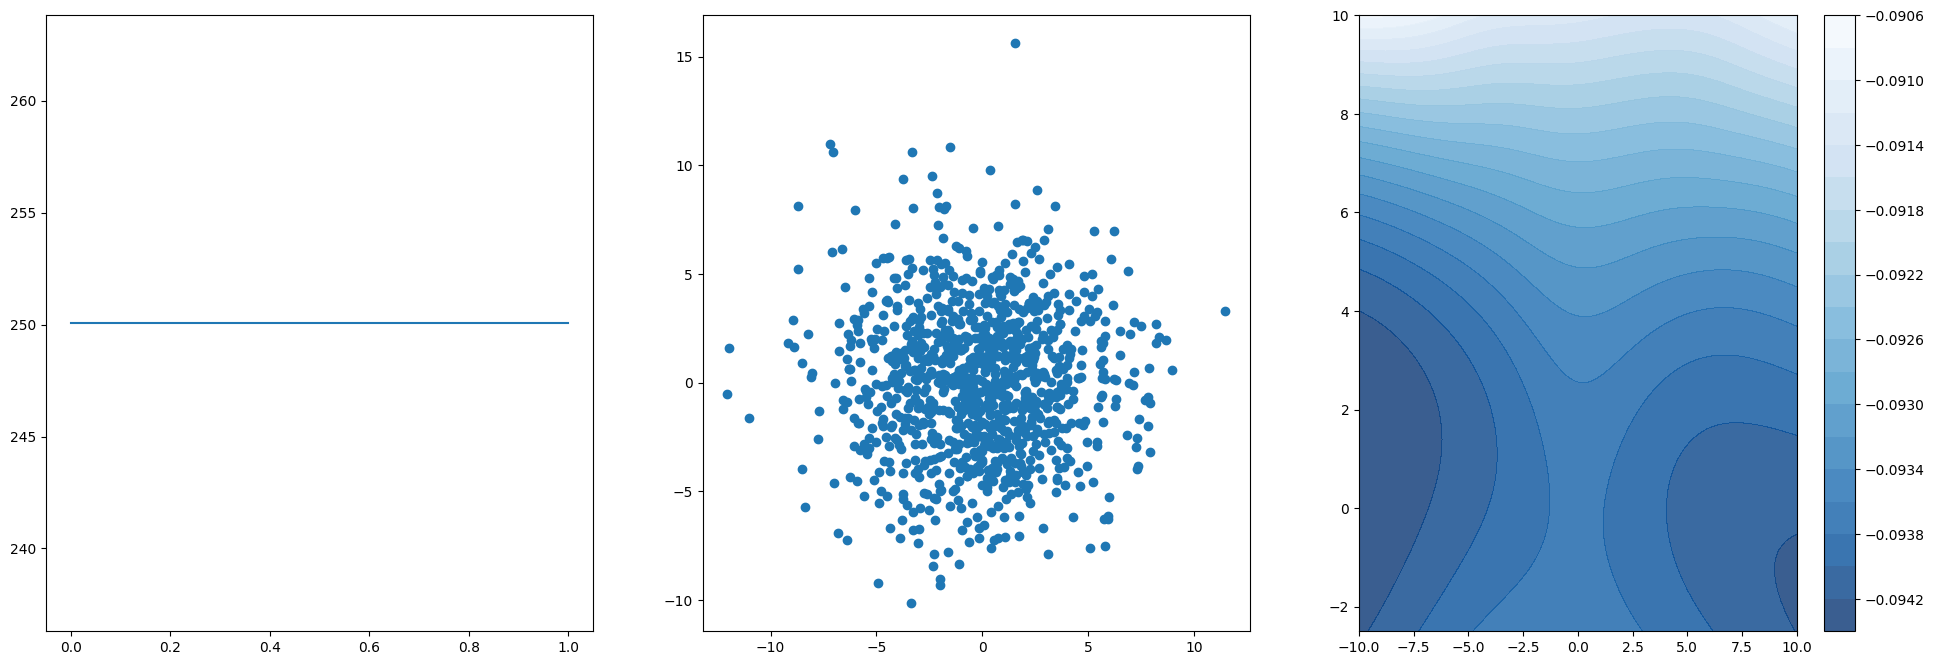

100 -- loss : 145.543472
200 -- loss : 110.494293
300 -- loss : 140.576126
400 -- loss : 114.037918
500 -- loss : 113.226814
600 -- loss : 89.382416
700 -- loss : 87.874512
800 -- loss : 150.064453
900 -- loss : 149.229309
1000 -- loss : 118.636032


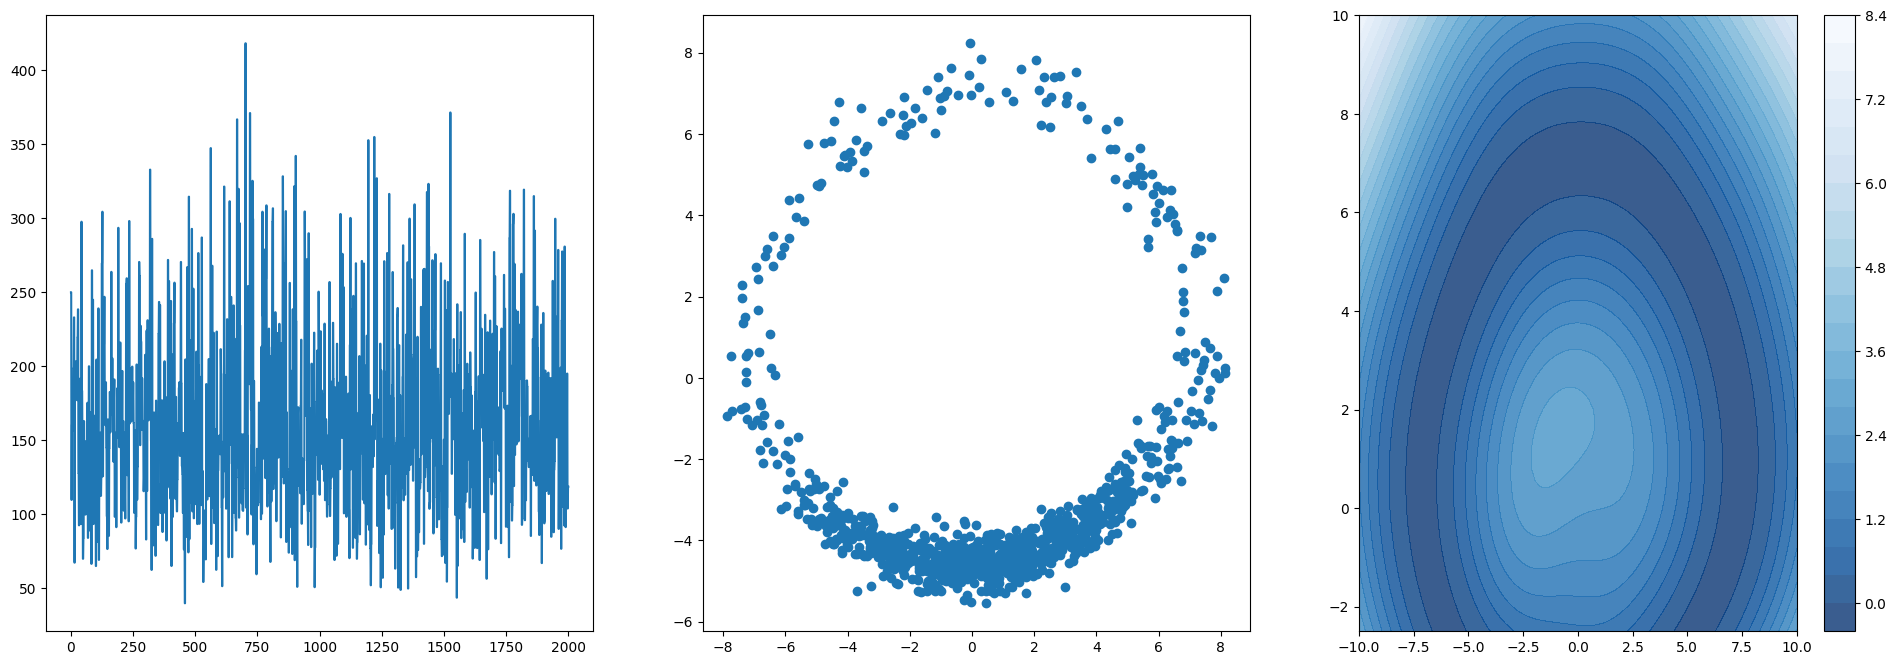

1100 -- loss : 212.465240
1200 -- loss : 262.744629
1300 -- loss : 312.350464
1400 -- loss : 91.034607
1500 -- loss : 86.182625
1600 -- loss : 290.851654
1700 -- loss : 159.921997
1800 -- loss : 53.212914
1900 -- loss : 160.212372
2000 -- loss : 136.338898


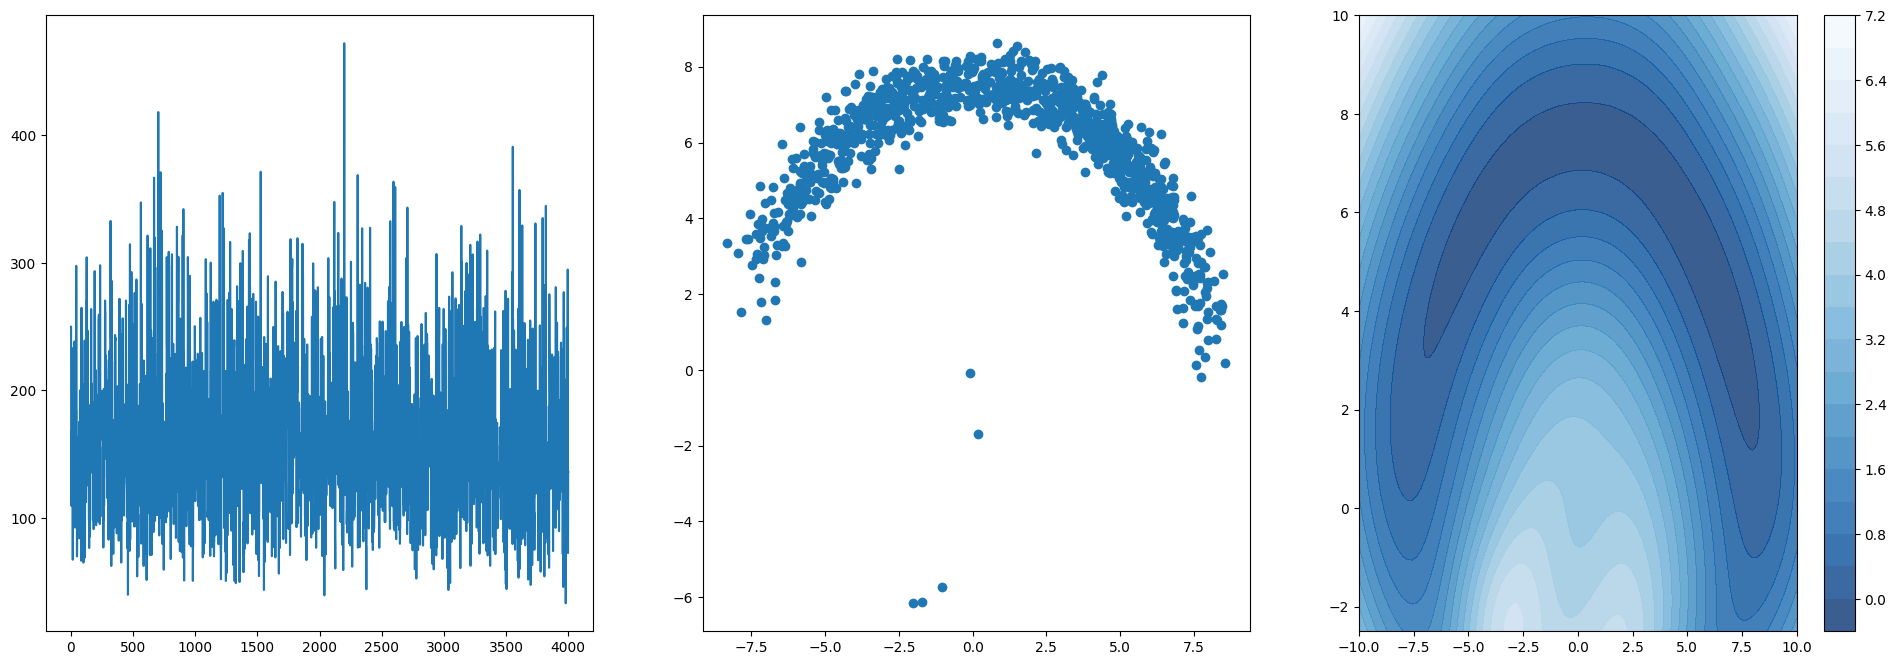

2100 -- loss : 79.888908
2200 -- loss : 160.827179
2300 -- loss : 179.681808
2400 -- loss : 163.502930
2500 -- loss : 174.286423
2600 -- loss : 232.124603
2700 -- loss : 167.167130
2800 -- loss : 113.342674
2900 -- loss : 83.528336
3000 -- loss : 183.156128


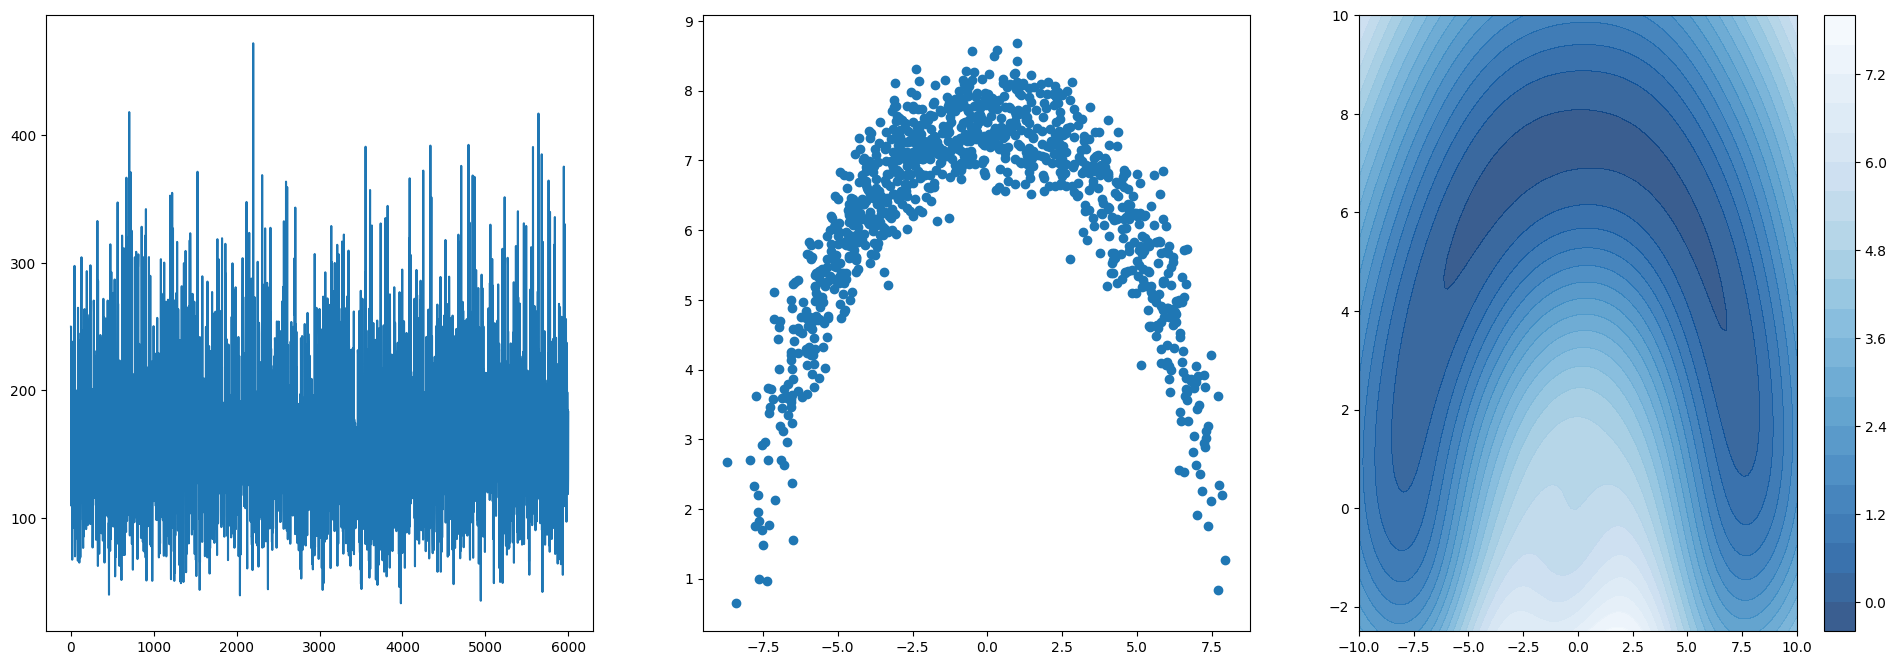

3100 -- loss : 100.945419
3200 -- loss : 126.142052
3300 -- loss : 153.638443
3400 -- loss : 339.672028
3500 -- loss : 228.909973
3600 -- loss : 162.166595
3700 -- loss : 188.254425
3800 -- loss : 95.698318
3900 -- loss : 190.375076
4000 -- loss : 84.000801


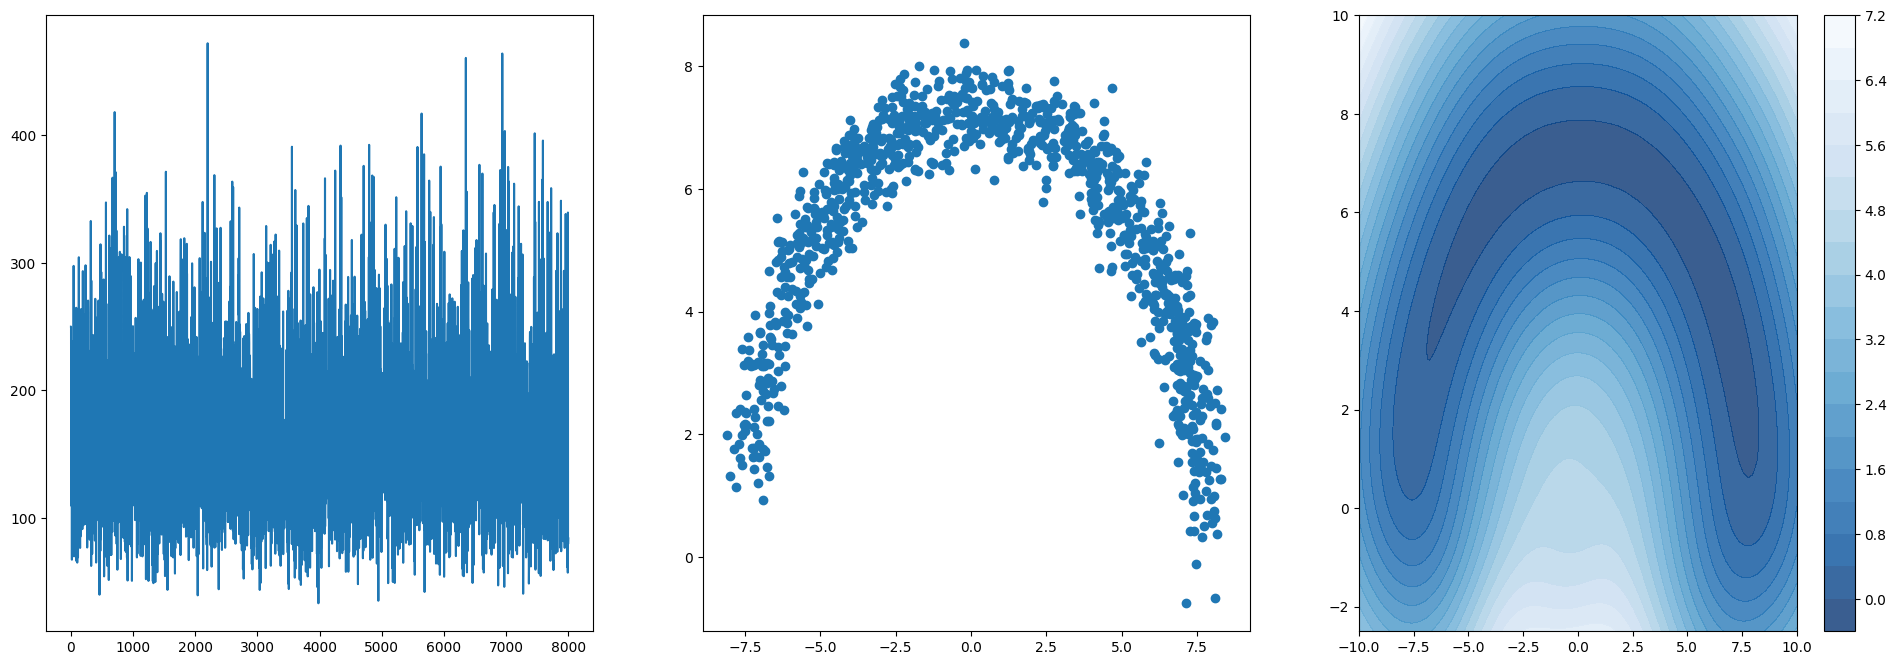

4100 -- loss : 329.266205
4200 -- loss : 89.945755
4300 -- loss : 152.634277
4400 -- loss : 204.753784
4500 -- loss : 64.168137
4600 -- loss : 154.598709
4700 -- loss : 98.637817
4800 -- loss : 154.117188
4900 -- loss : 245.707260
5000 -- loss : 145.337494


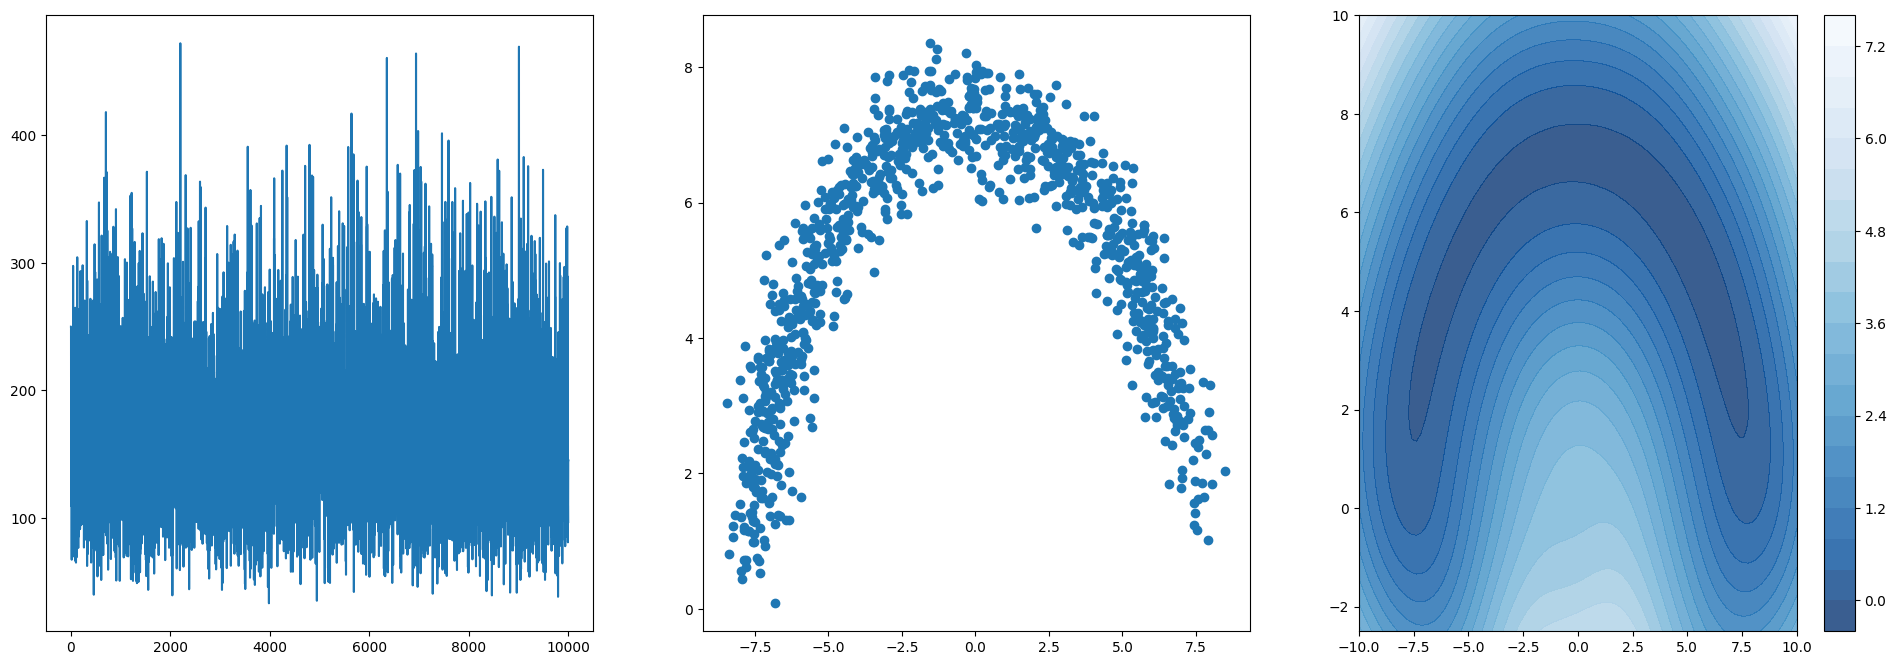

5100 -- loss : 241.972198
5200 -- loss : 149.178101
5300 -- loss : 155.903900
5400 -- loss : 173.012619
5500 -- loss : 102.059181
5600 -- loss : 265.755005
5700 -- loss : 151.825150
5800 -- loss : 347.759430
5900 -- loss : 159.058929
6000 -- loss : 200.305084


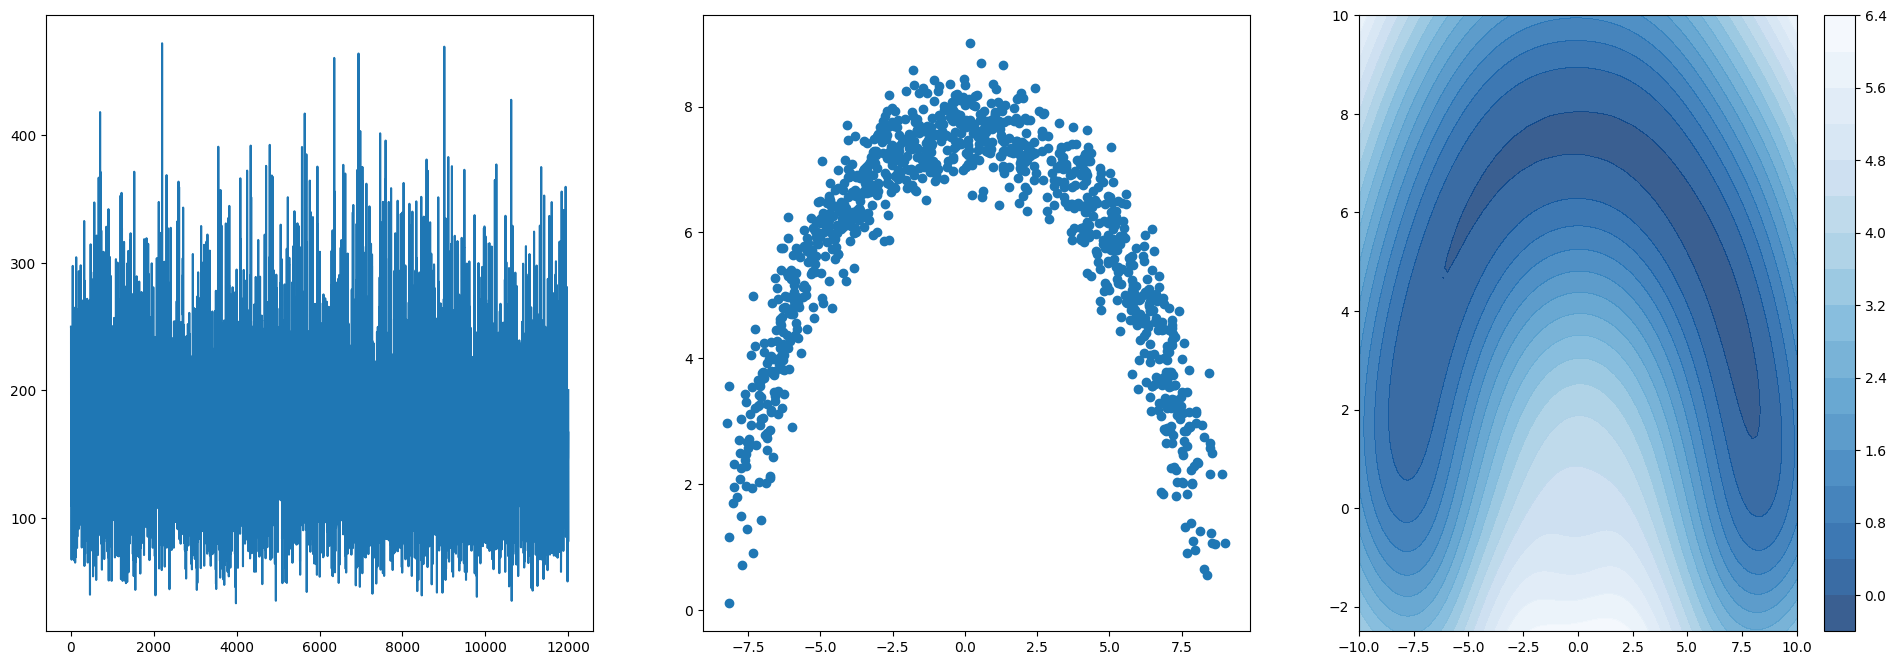

6100 -- loss : 354.219635
6200 -- loss : 267.792786
6300 -- loss : 157.177490
6400 -- loss : 171.912659
6500 -- loss : 131.022568
6600 -- loss : 324.709961
6700 -- loss : 145.277008
6800 -- loss : 100.201843
6900 -- loss : 83.035034
7000 -- loss : 129.499908


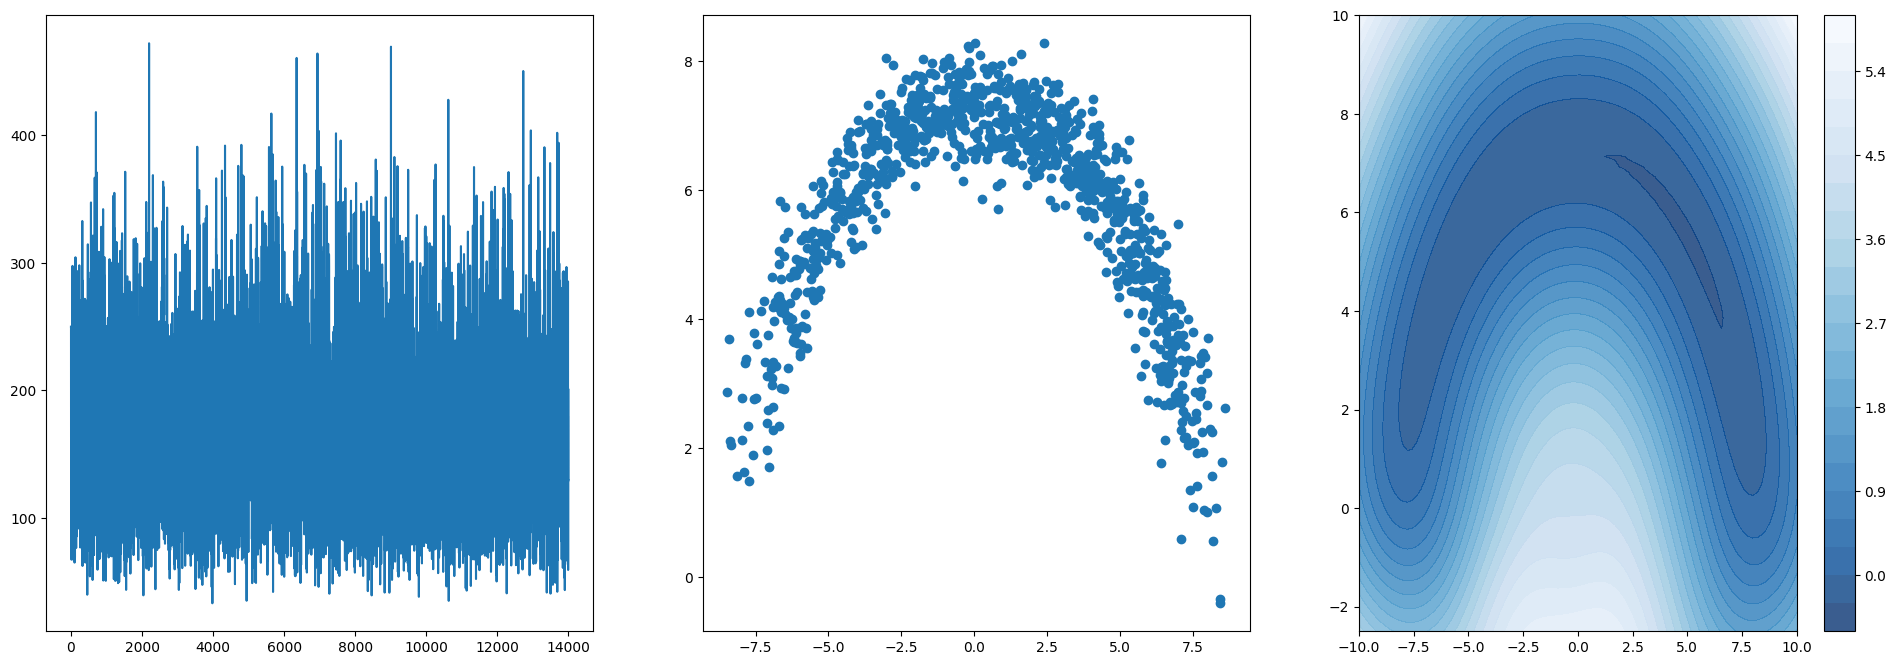

7100 -- loss : 123.086868
7200 -- loss : 208.309570
7300 -- loss : 70.254105
7400 -- loss : 194.589233
7500 -- loss : 78.610184
7600 -- loss : 246.924988
7700 -- loss : 145.480927
7800 -- loss : 131.440598
7900 -- loss : 155.870468
8000 -- loss : 46.841942


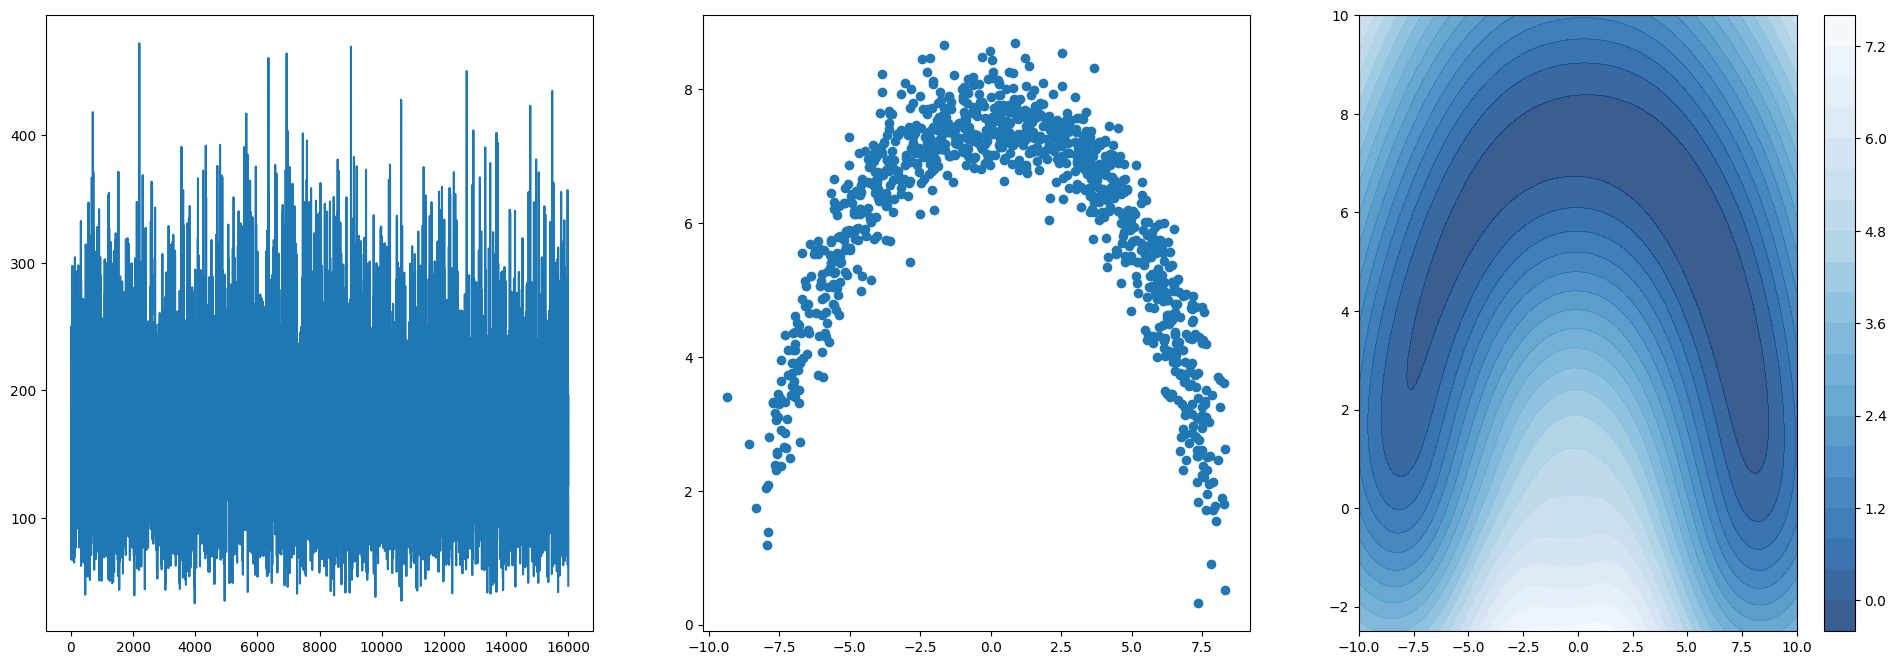

8100 -- loss : 169.192993
8200 -- loss : 140.105850
8300 -- loss : 51.442966
8400 -- loss : 110.997078
8500 -- loss : 148.053619
8600 -- loss : 122.380966
8700 -- loss : 107.644852
8800 -- loss : 153.698929
8900 -- loss : 186.076019
9000 -- loss : 123.579086


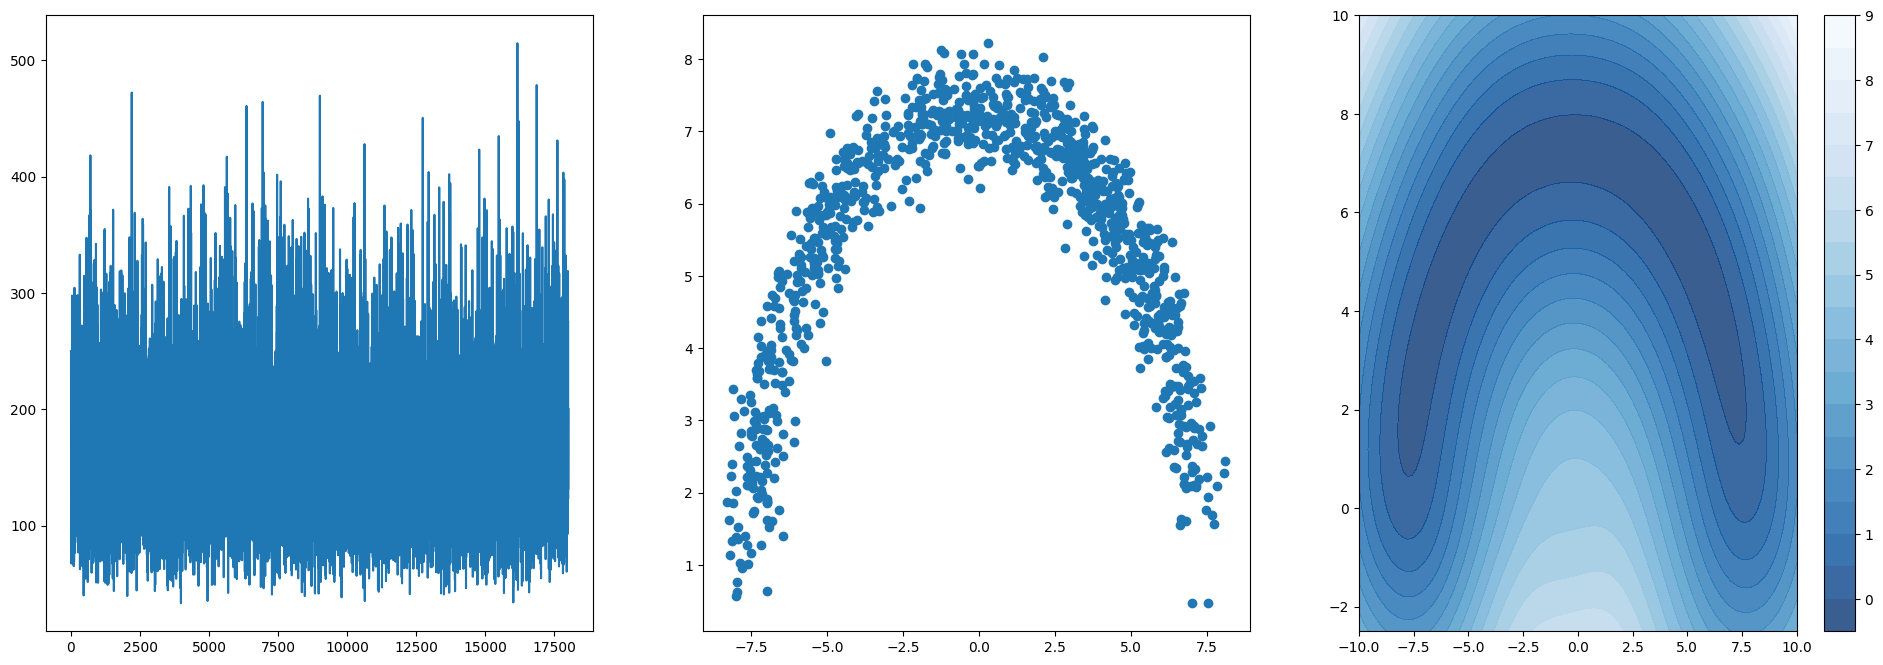

9100 -- loss : 90.949951
9200 -- loss : 282.844971
9300 -- loss : 160.601944
9400 -- loss : 199.994690
9500 -- loss : 161.964111
9600 -- loss : 255.335297
9700 -- loss : 170.016357
9800 -- loss : 143.194794
9900 -- loss : 114.311035
10000 -- loss : 162.157120


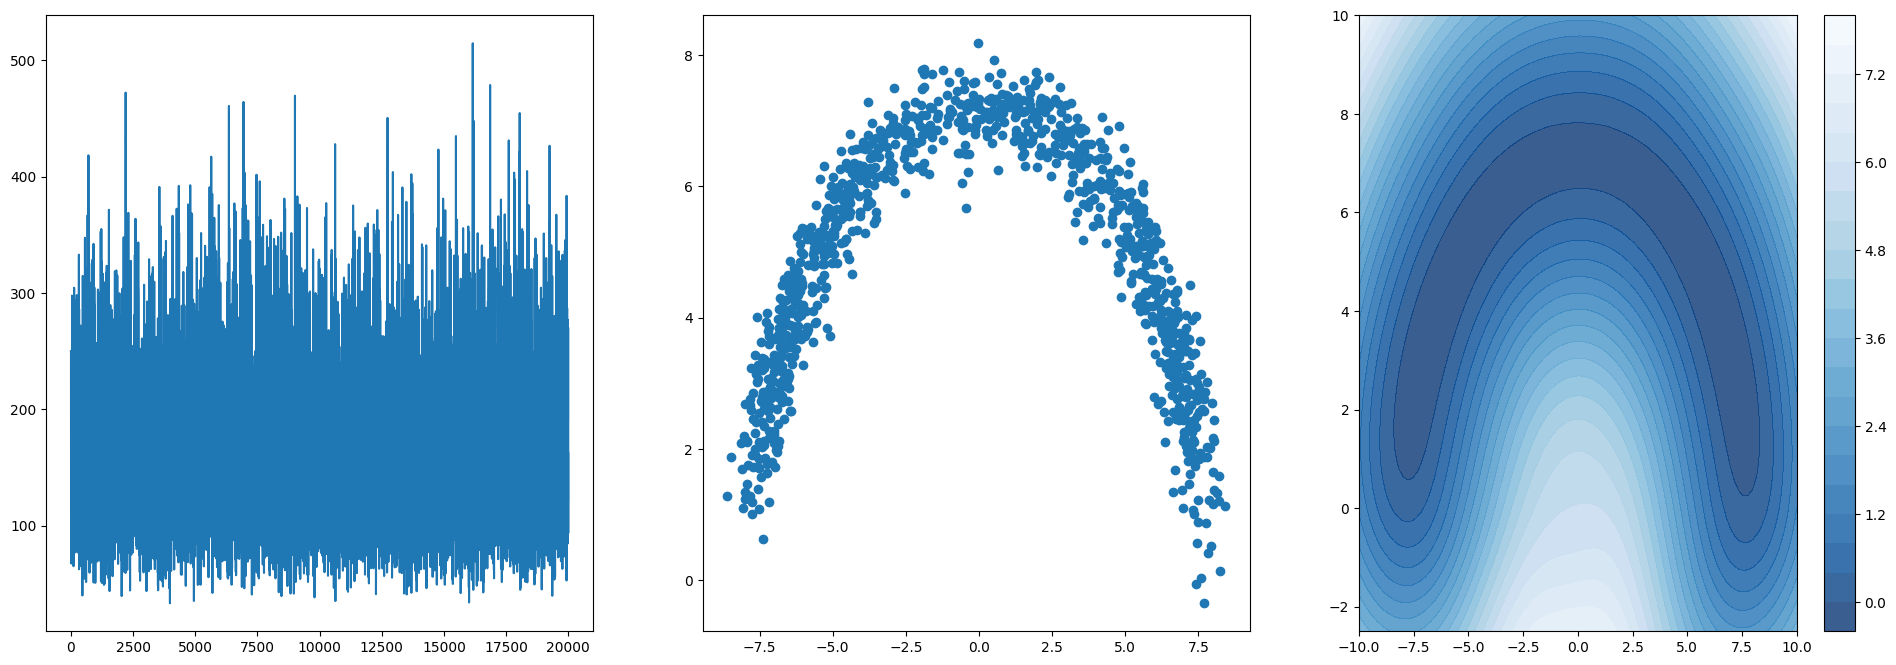

10100 -- loss : 152.119019
10200 -- loss : 253.730484
10300 -- loss : 159.110458
10400 -- loss : 159.175735
10500 -- loss : 261.338959
10600 -- loss : 137.354324
10700 -- loss : 170.501709
10800 -- loss : 272.683685
10900 -- loss : 137.005692
11000 -- loss : 146.321671


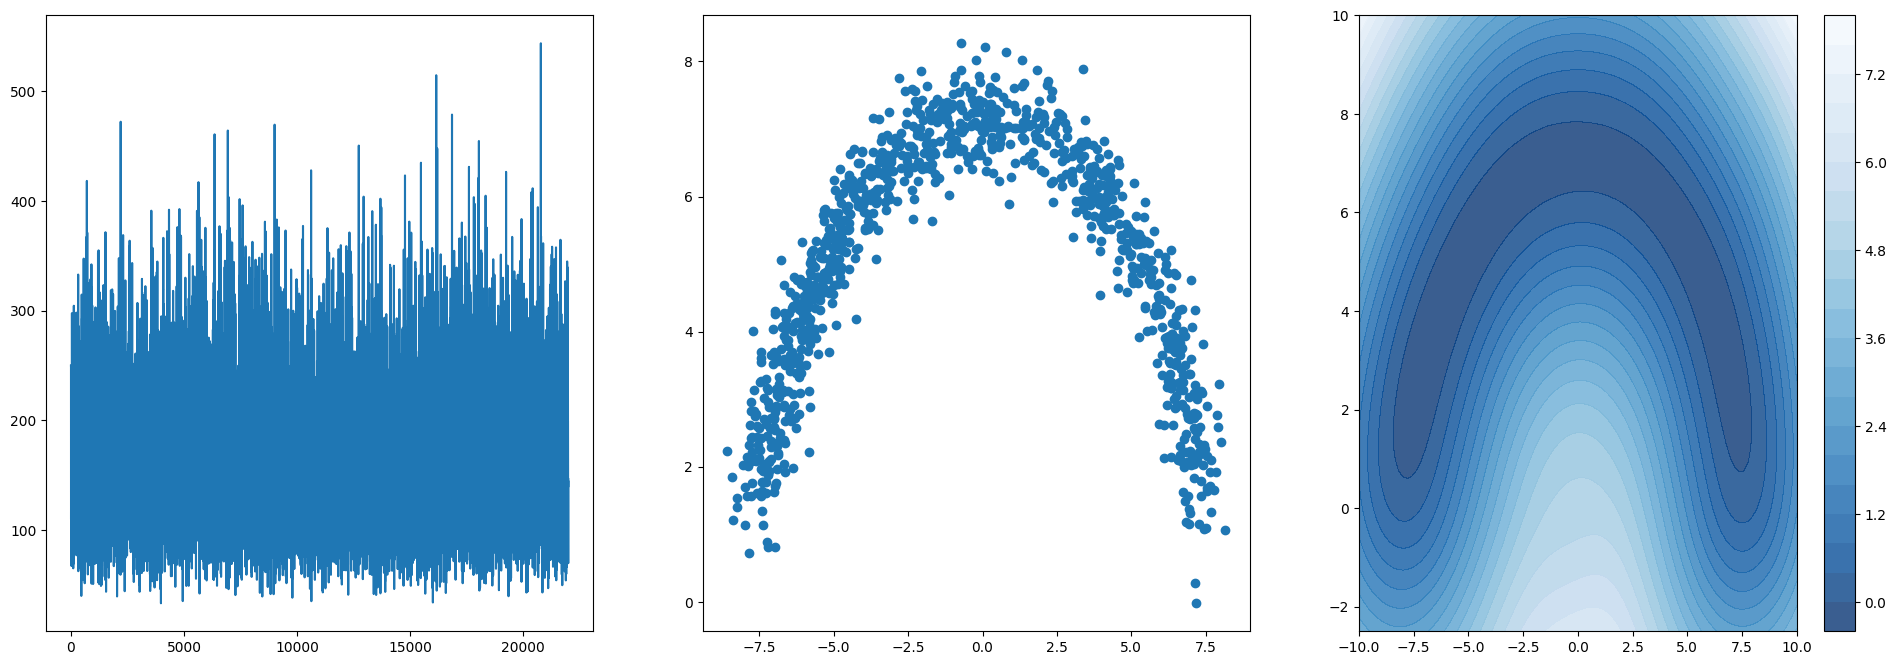

11100 -- loss : 120.895172
11200 -- loss : 102.550446
11300 -- loss : 67.700073
11400 -- loss : 180.703735
11500 -- loss : 99.569839
11600 -- loss : 147.029160
11700 -- loss : 139.855057
11800 -- loss : 281.691925
11900 -- loss : 143.830078
12000 -- loss : 165.895508


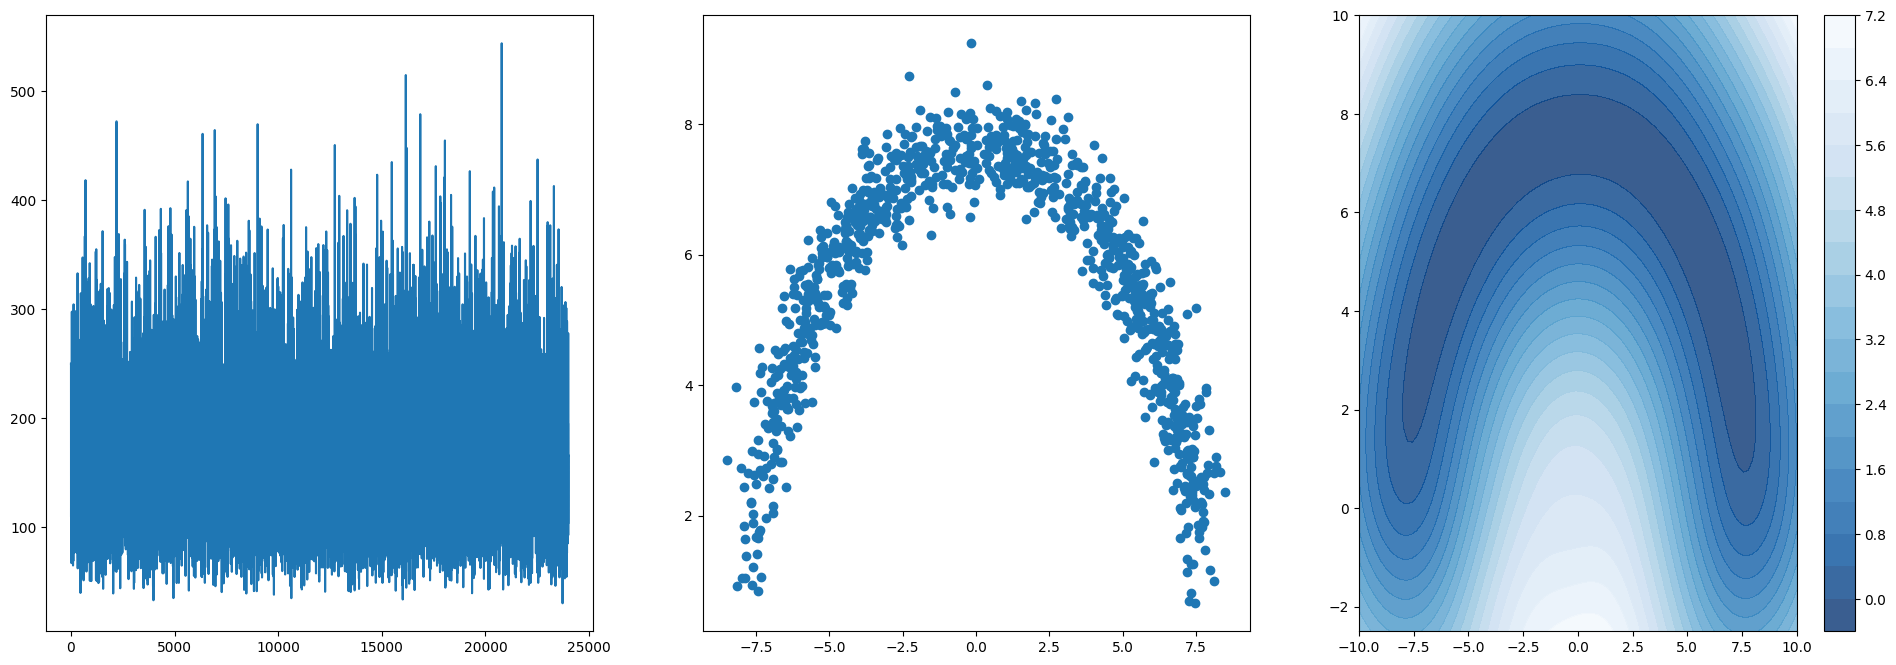

12100 -- loss : 139.222137
12200 -- loss : 415.266296
12300 -- loss : 122.532425
12400 -- loss : 174.790375
12500 -- loss : 81.965752
12600 -- loss : 140.772217
12700 -- loss : 173.999237
12800 -- loss : 78.292755
12900 -- loss : 167.261200
13000 -- loss : 184.659302


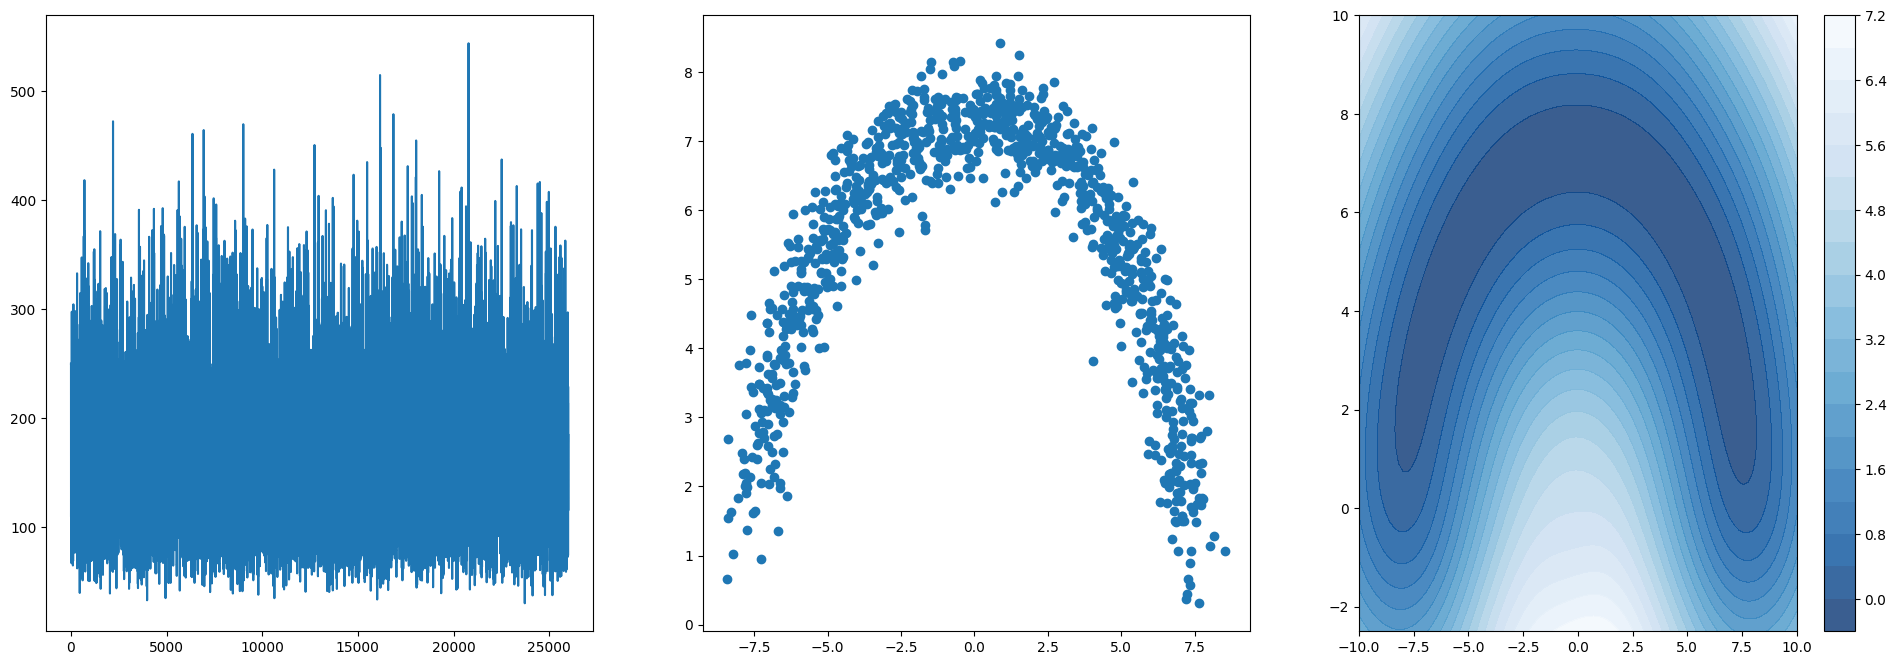

13100 -- loss : 184.774704
13200 -- loss : 98.353531
13300 -- loss : 174.359314
13400 -- loss : 107.060181
13500 -- loss : 168.502243
13600 -- loss : 202.605209
13700 -- loss : 88.758347
13800 -- loss : 107.037186
13900 -- loss : 140.443298
14000 -- loss : 174.184998


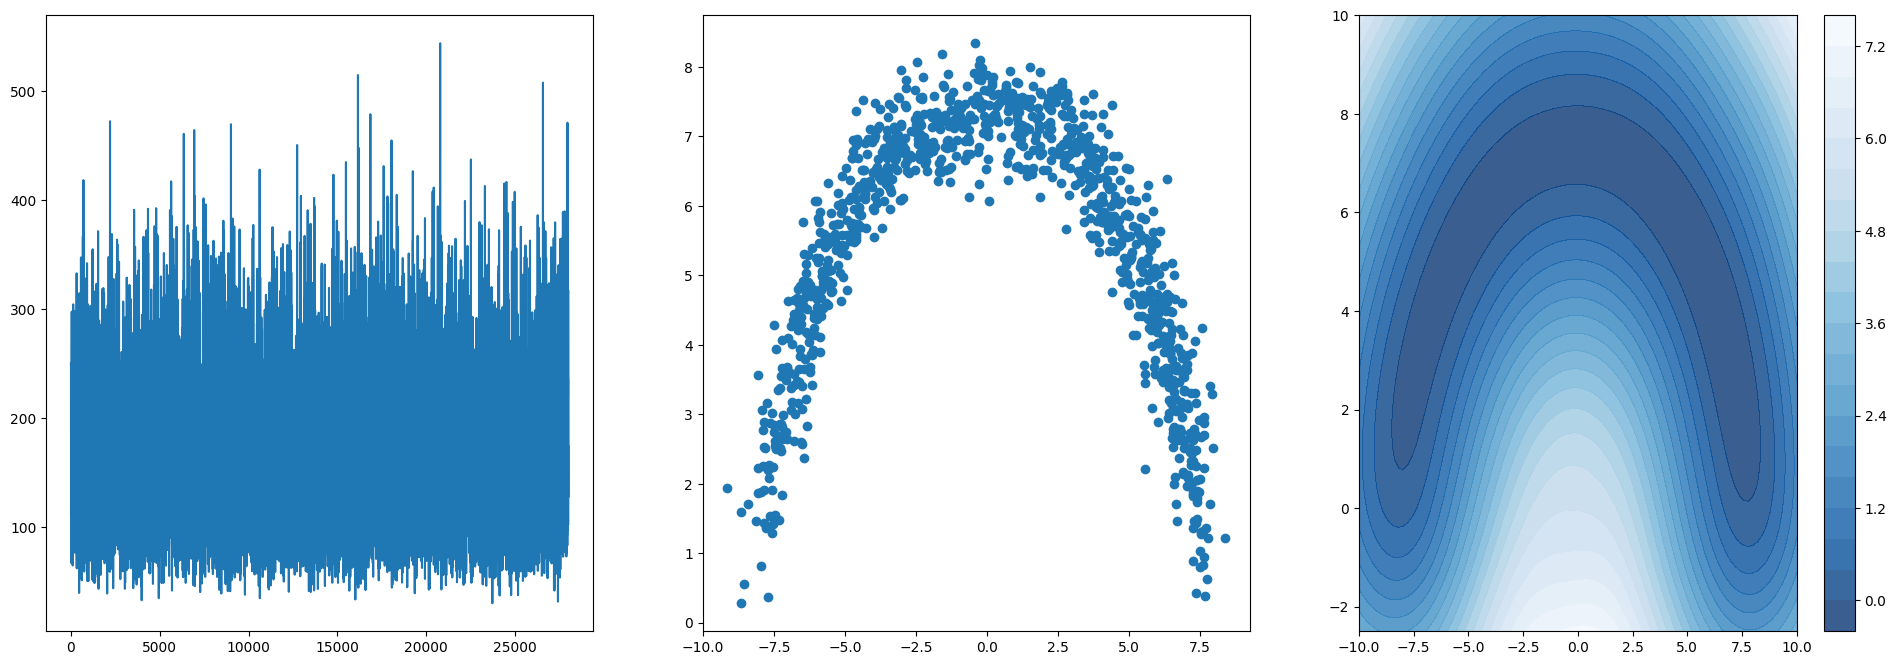

14100 -- loss : 251.776886
14200 -- loss : 269.943573
14300 -- loss : 231.067749
14400 -- loss : 207.345764
14500 -- loss : 186.314331
14600 -- loss : 96.870605
14700 -- loss : 214.419922
14800 -- loss : 230.347351
14900 -- loss : 360.565918
15000 -- loss : 175.210327


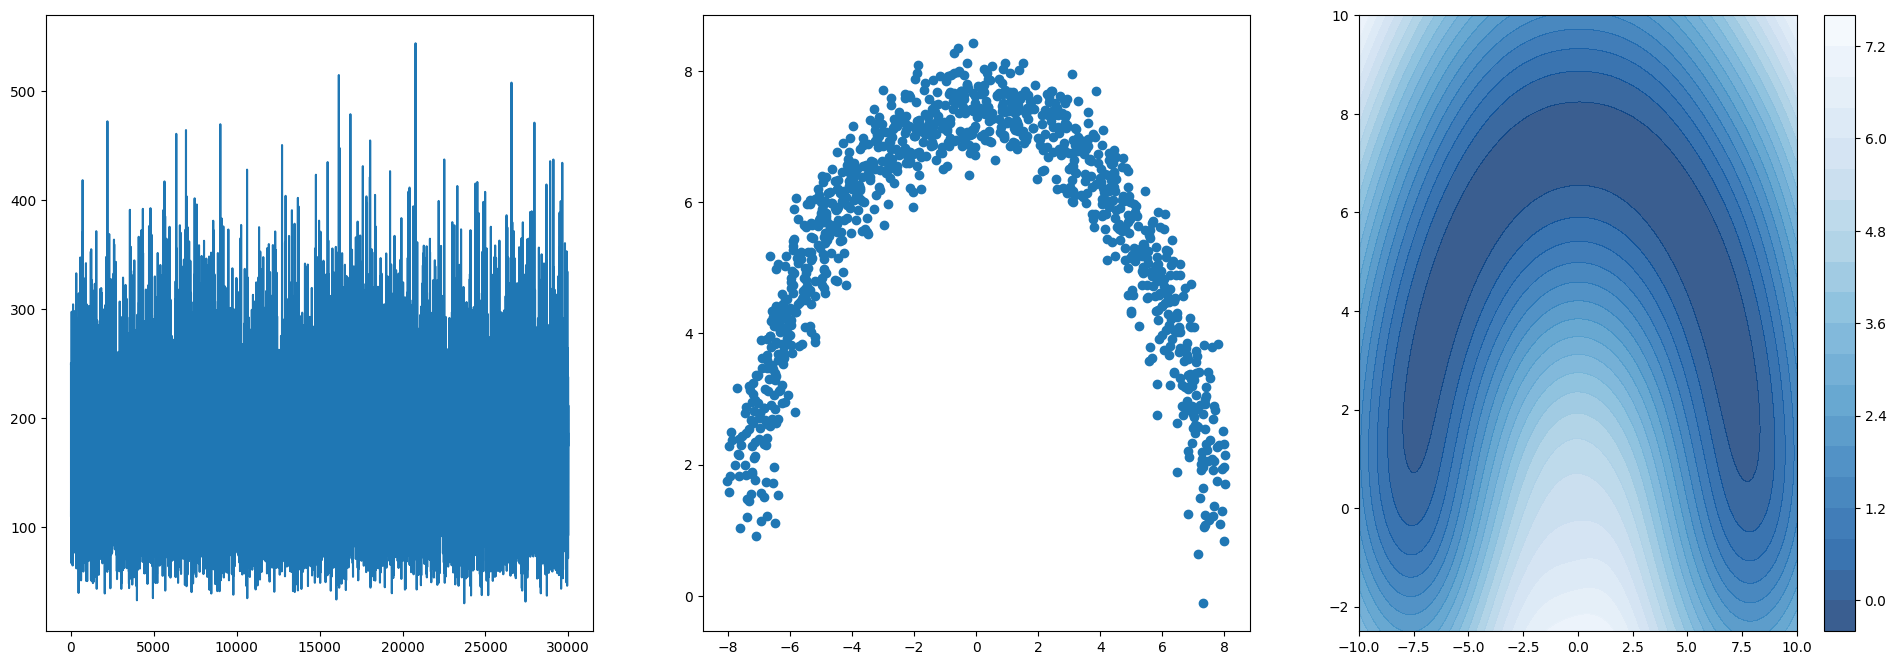

15100 -- loss : 135.057449
15200 -- loss : 109.354630
15300 -- loss : 120.795639
15400 -- loss : 220.279907
15500 -- loss : 169.880966
15600 -- loss : 63.174328
15700 -- loss : 203.954285
15800 -- loss : 112.575356
15900 -- loss : 121.400314
16000 -- loss : 302.567627


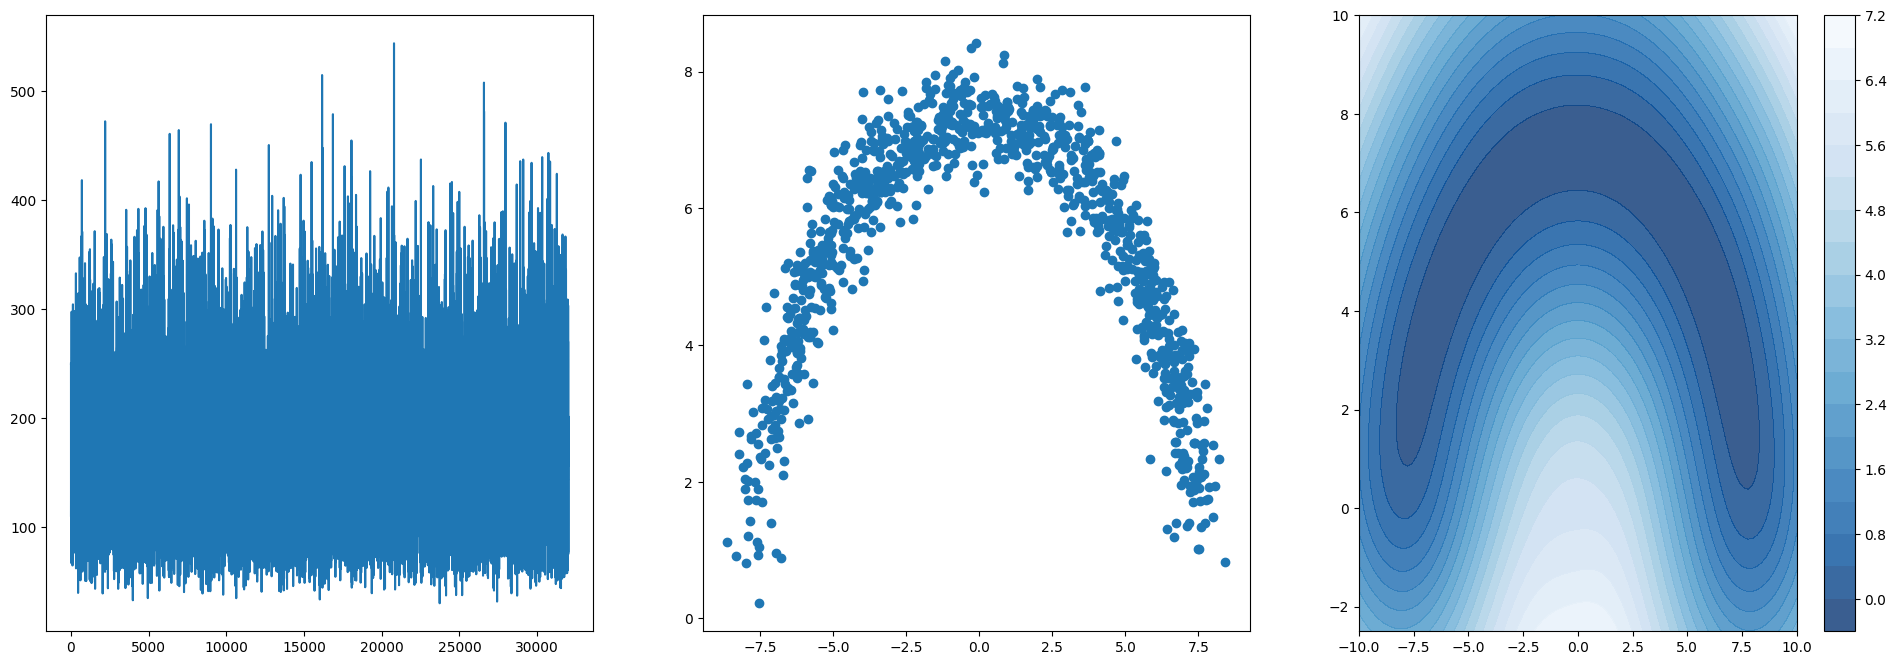

16100 -- loss : 144.791534
16200 -- loss : 280.992798
16300 -- loss : 247.447113
16400 -- loss : 214.467850
16500 -- loss : 201.422882
16600 -- loss : 151.972290
16700 -- loss : 175.201797
16800 -- loss : 190.199615
16900 -- loss : 178.729324
17000 -- loss : 106.294800


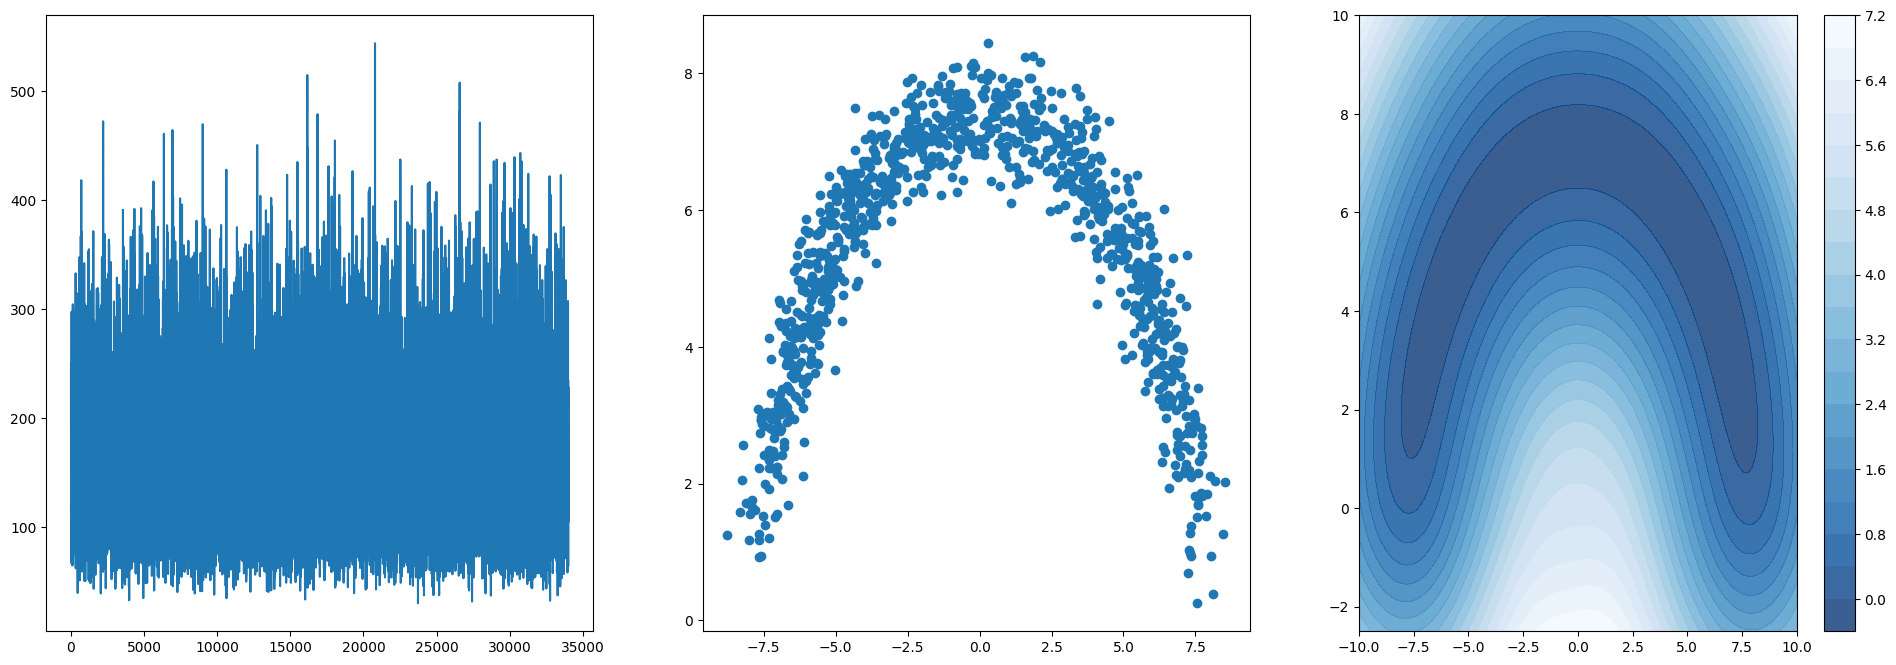

17100 -- loss : 198.980865
17200 -- loss : 310.684021
17300 -- loss : 172.180817
17400 -- loss : 184.252625
17500 -- loss : 98.933228
17600 -- loss : 156.289673
17700 -- loss : 133.554718
17800 -- loss : 173.653687
17900 -- loss : 233.698807
18000 -- loss : 110.014664


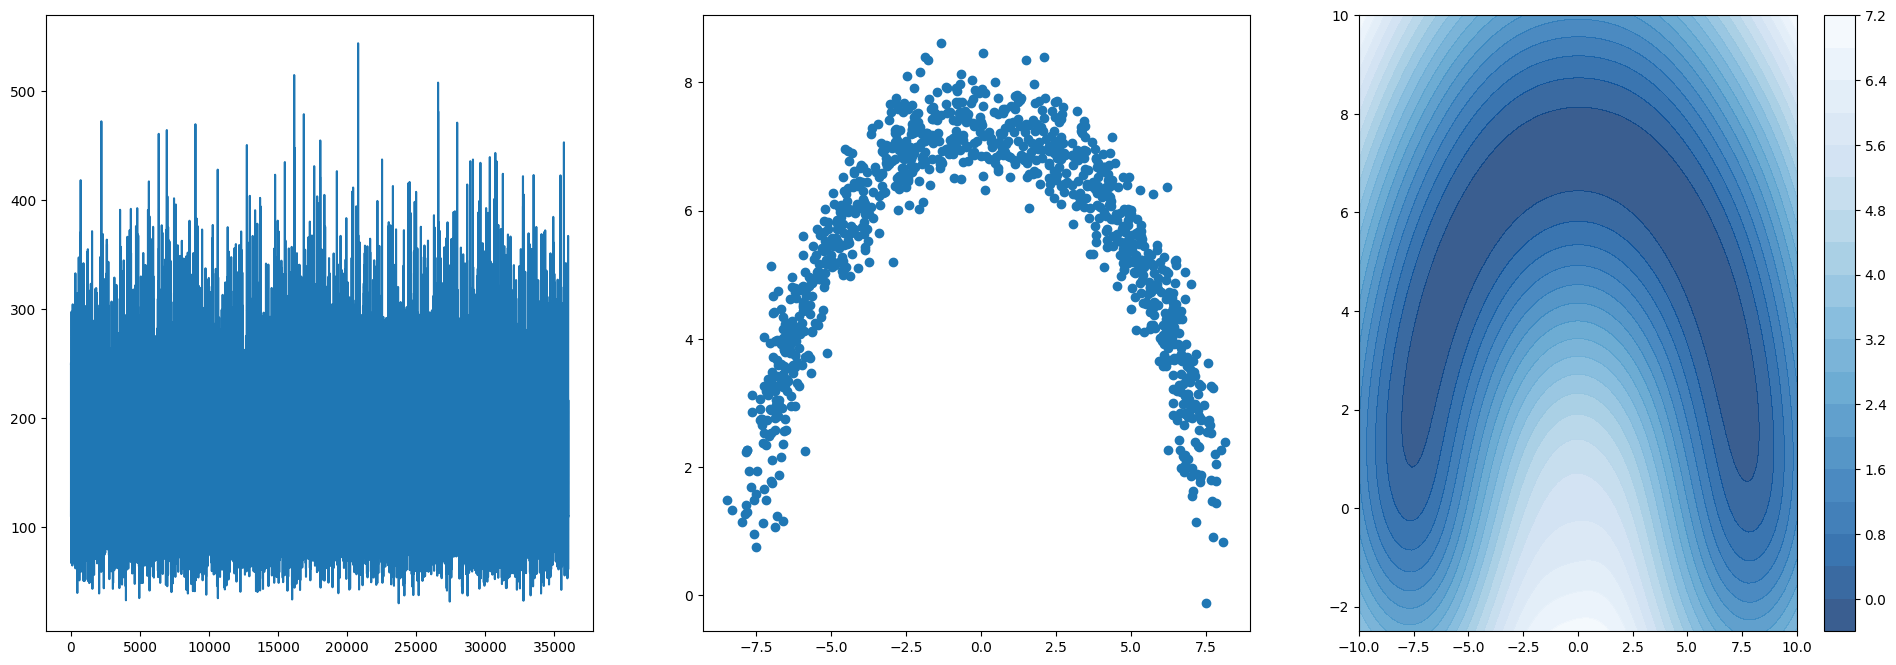

18100 -- loss : 204.401306
18200 -- loss : 43.977371
18300 -- loss : 106.775551
18400 -- loss : 136.559265
18500 -- loss : 204.153931
18600 -- loss : 68.242767
18700 -- loss : 191.106079
18800 -- loss : 122.202728
18900 -- loss : 86.520744
19000 -- loss : 170.738754


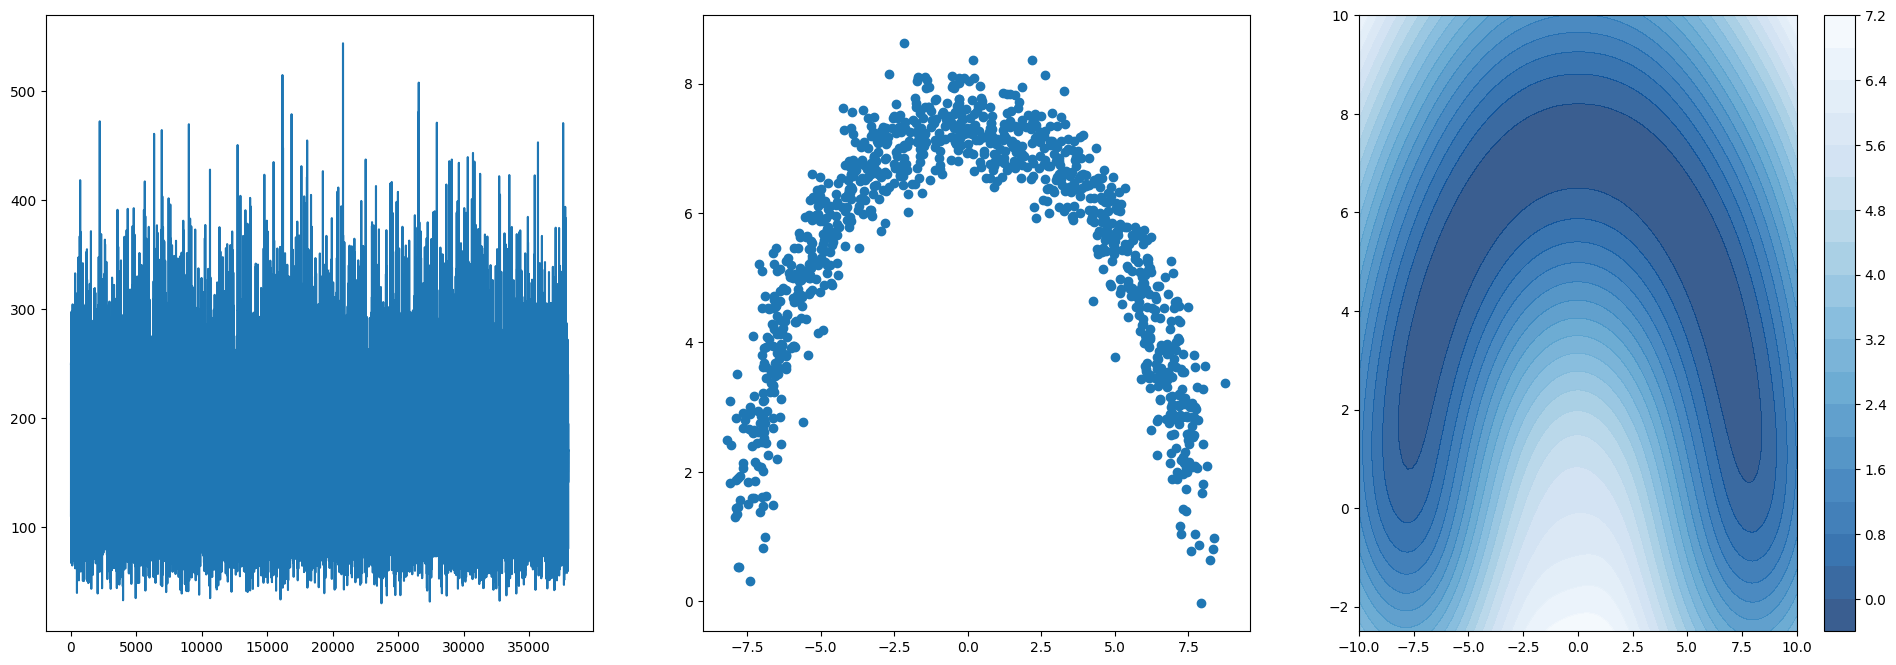

19100 -- loss : 152.847931
19200 -- loss : 196.554947
19300 -- loss : 256.810791
19400 -- loss : 174.800842
19500 -- loss : 99.701248
19600 -- loss : 263.756622
19700 -- loss : 117.384232
19800 -- loss : 190.909790
19900 -- loss : 176.748047


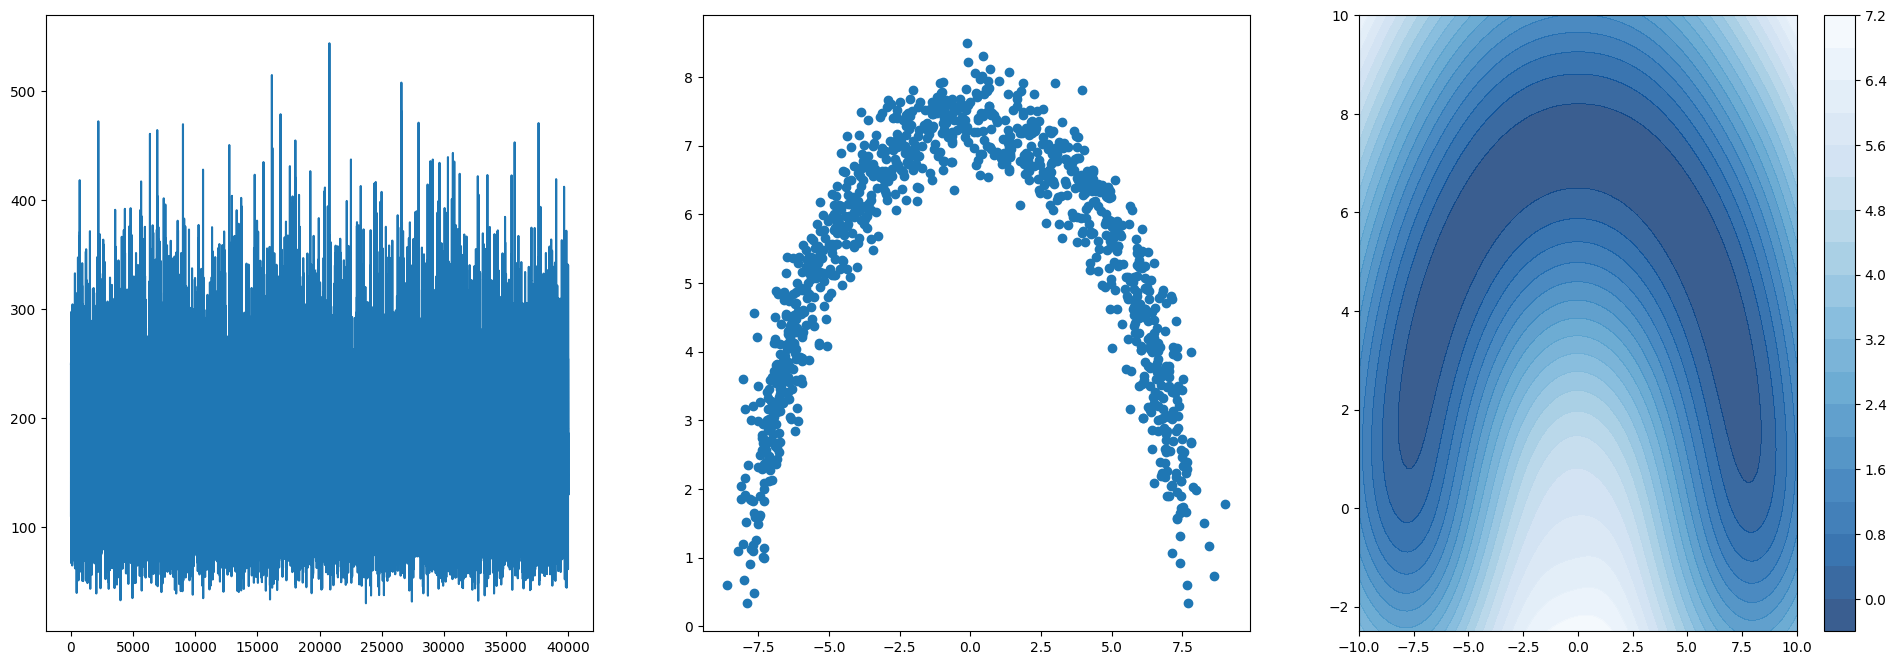

In [7]:
## Network 
SGLD_STEPS = 1000
SGLD_STD = 1e-1
SGLD_LR = 0.05
EPOCH = 20000
BATCH_SIZE = 1024
netE = MLP_ELU_convex().to(DEVICE)
en = lambda x: netE(x) 

train_EBM=True
if train_EBM:
    optimizer = torch.optim.Adam(netE.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, EPOCH, eta_min=1e-6)
    all_loss = []
    for i in range(EPOCH):
        optimizer.zero_grad()
        x = mixture_1.sample(BATCH_SIZE)
        
        sigma = (torch.randint(1,200, (BATCH_SIZE,)).float()/100.0).unsqueeze(1).to(DEVICE)
        x_noisy = x + torch.randn_like(x) * sigma
        x_noisy.requires_grad_(True)
        score_estimate = -torch.autograd.grad(en(x_noisy).sum(), x_noisy, create_graph=True)[0]
        score_target = -(x_noisy - x) / sigma**2

        
        loss = ((score_estimate - score_target)**2).sum(dim=1).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        all_loss.append(loss.item())

        
        all_loss.append(loss.item())
        if i % 100 ==0 :
            print(f"{i} -- loss : {loss.item():0.6f}")
        if i % 1000 == 0 or i == EPOCH-1:
        
            x_i = torch.randn_like(x)
            x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
            all_e = en(pos)
            fig, ax = plt.subplots(1, 3, figsize=(3*8,8))
            ax[0].plot(all_loss)
            ax[1].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
            im = ax[2].contourf(x_p, y_p, all_e.view(62,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
            fig.colorbar(im, ax=ax[2])
            plt.show()
    to_save = {"weight": netE.state_dict(),
               "type": type(netE)}
    torch.save(to_save, f"./EBM_mixture1.pth")
else:
    ckpt = torch.load(f"./EBM_mixture1.pth", weights_only=False)
    netE.load_state_dict(ckpt["weight"], strict=True)
    en = lambda x: netE(x)
    x_i = torch.randn(BATCH_SIZE, 2).to(DEVICE)
    x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
    #x_p, y_p = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100), indexing='xy')
    #pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)
    all_e = en(pos)
    fig, ax = plt.subplots(1, 2, figsize=(2*8,8))
    ax[0].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
    im = ax[1].contourf(x_p, y_p, all_e.view(62,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
    fig.colorbar(im, ax=ax[1])
    plt.show()
    

In [5]:
## Train the EBM on the non Uniformly distributed Gaussian mixture

0 -- loss : 496.980042


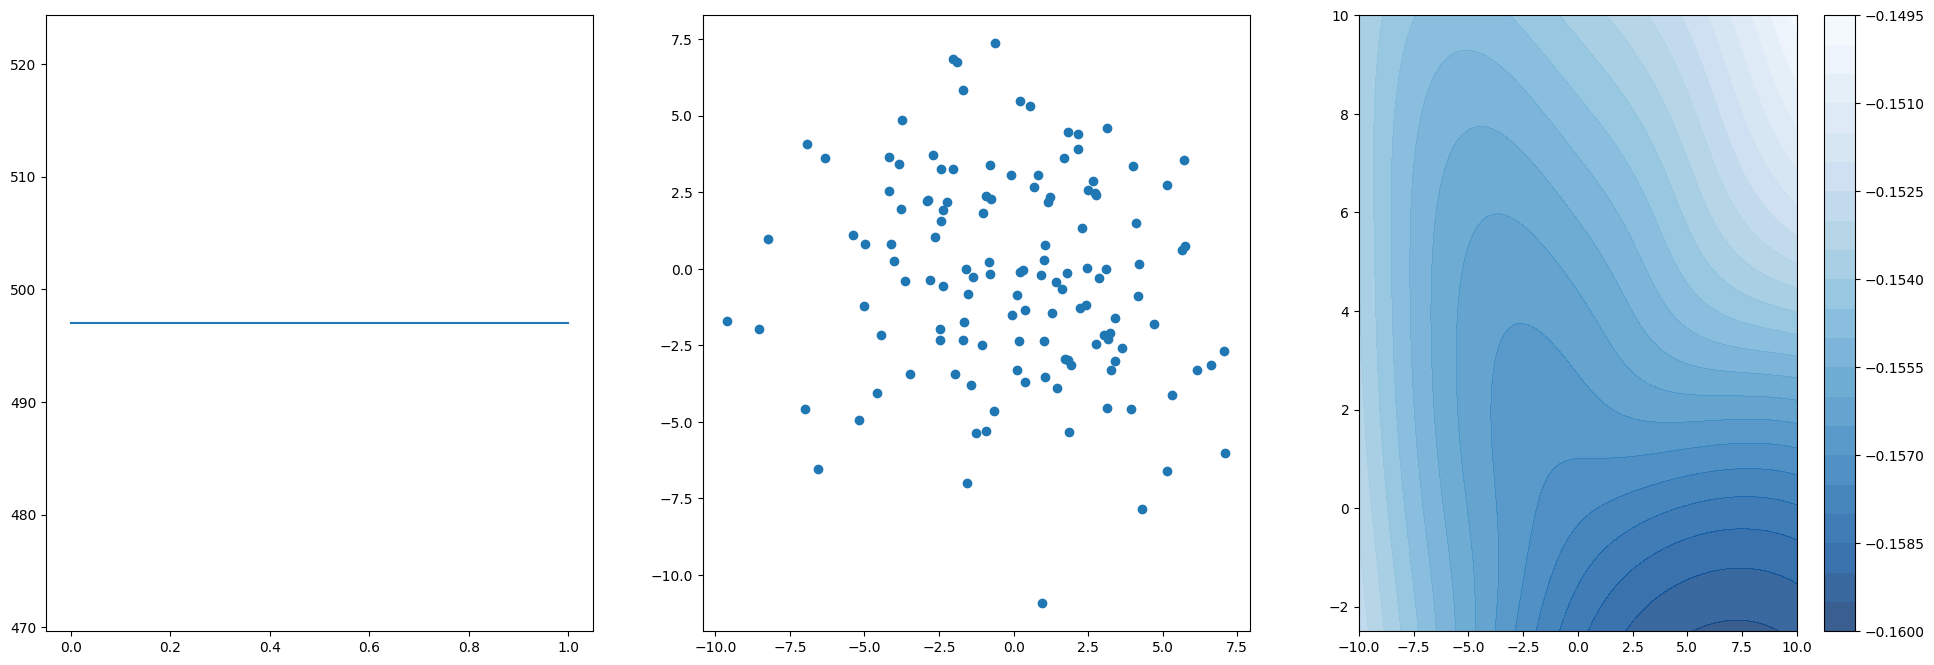

100 -- loss : 23.430681
200 -- loss : 82.121712
300 -- loss : 70.220322
400 -- loss : 55.386066
500 -- loss : 31.889038
600 -- loss : 36.241451
700 -- loss : 37.979771
800 -- loss : 384.864410
900 -- loss : 501.688782
1000 -- loss : 84.153046


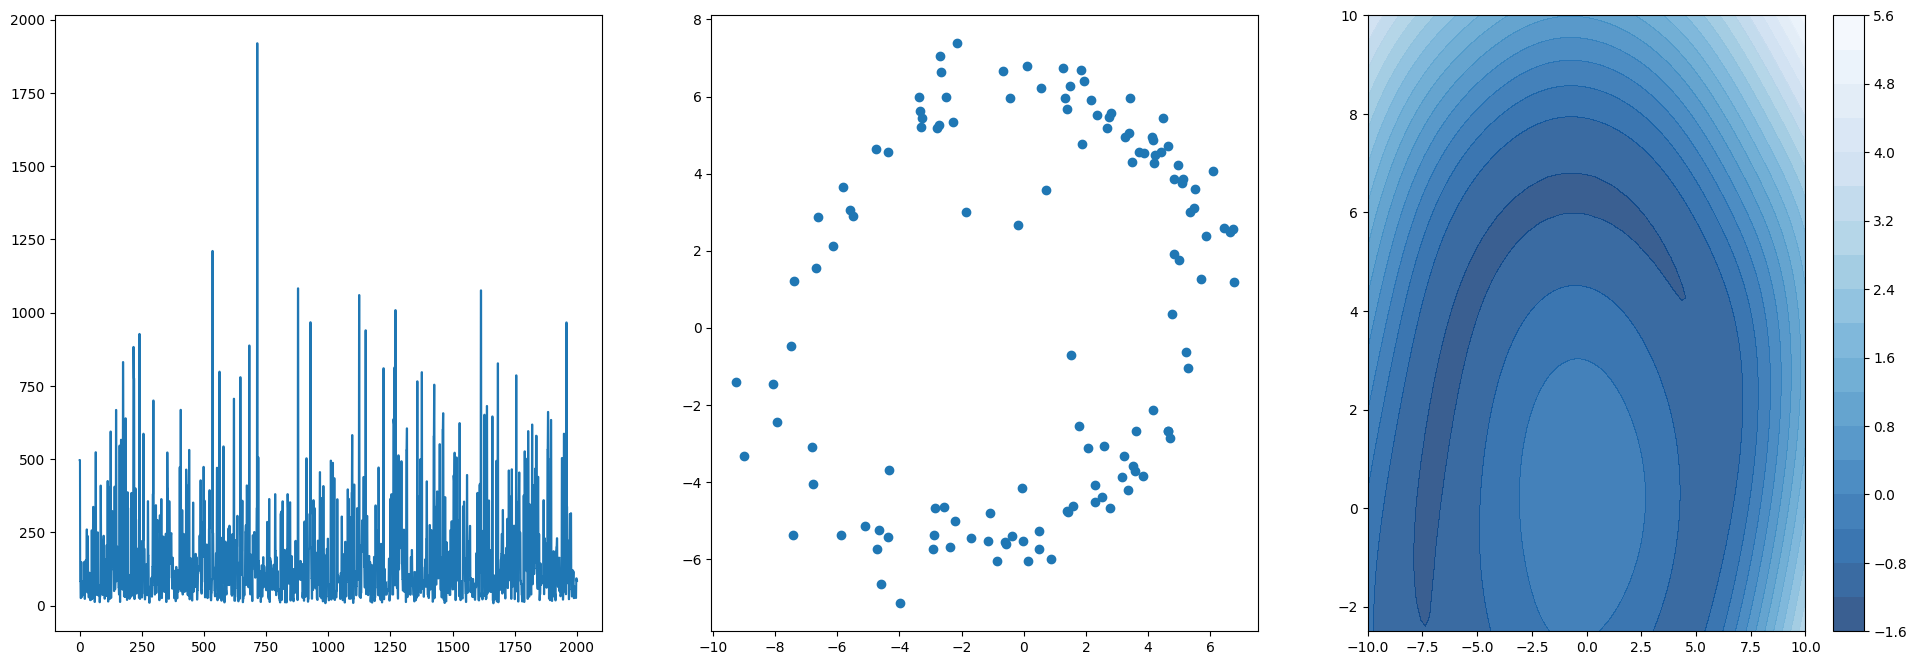

1100 -- loss : 12.830421
1200 -- loss : 74.071014
1300 -- loss : 37.668358
1400 -- loss : 22.128483
1500 -- loss : 25.155827
1600 -- loss : 40.013672
1700 -- loss : 505.097198
1800 -- loss : 94.606232
1900 -- loss : 34.147591
2000 -- loss : 52.148026


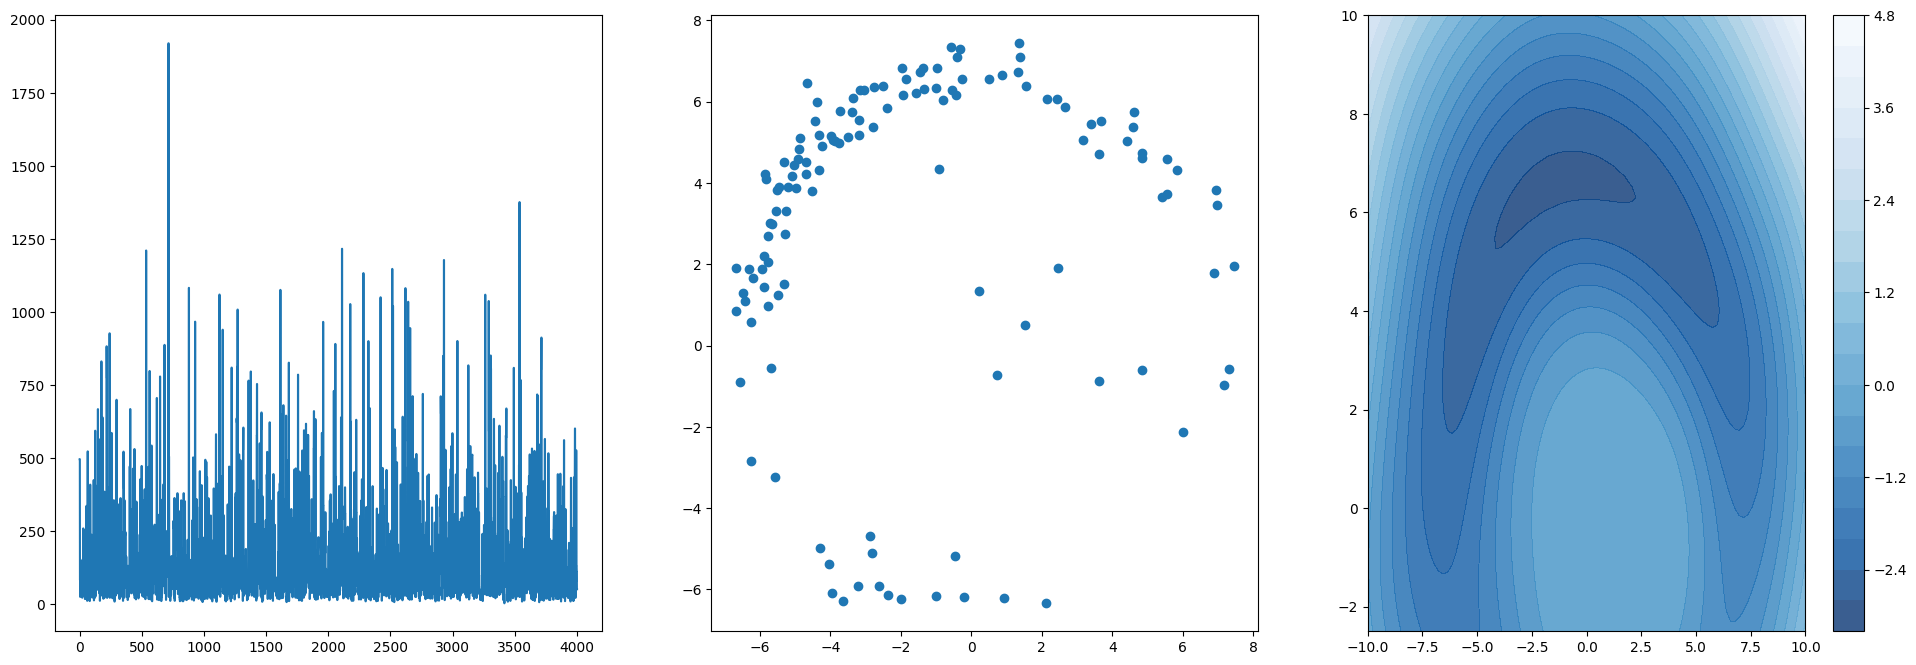

2100 -- loss : 120.849937
2200 -- loss : 15.458237
2300 -- loss : 246.790100
2400 -- loss : 509.646851
2500 -- loss : 131.808136
2600 -- loss : 27.267962
2700 -- loss : 70.860504
2800 -- loss : 163.704315
2900 -- loss : 74.541397
3000 -- loss : 41.389065


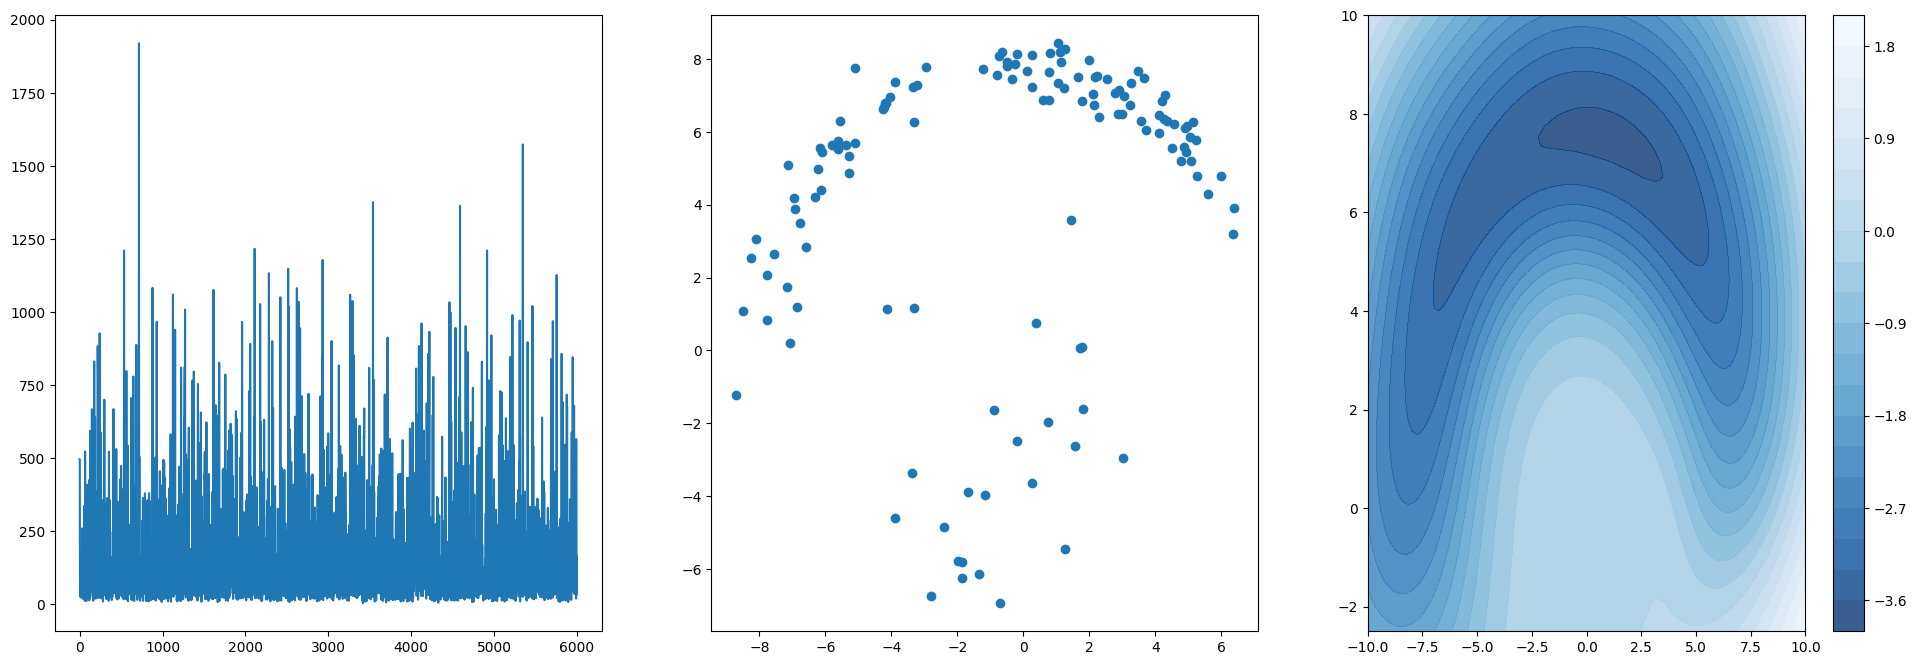

3100 -- loss : 278.571838
3200 -- loss : 486.193176
3300 -- loss : 146.763184
3400 -- loss : 284.342468
3500 -- loss : 18.921291
3600 -- loss : 12.419485
3700 -- loss : 376.717102
3800 -- loss : 146.860657
3900 -- loss : 172.192795
4000 -- loss : 63.417809


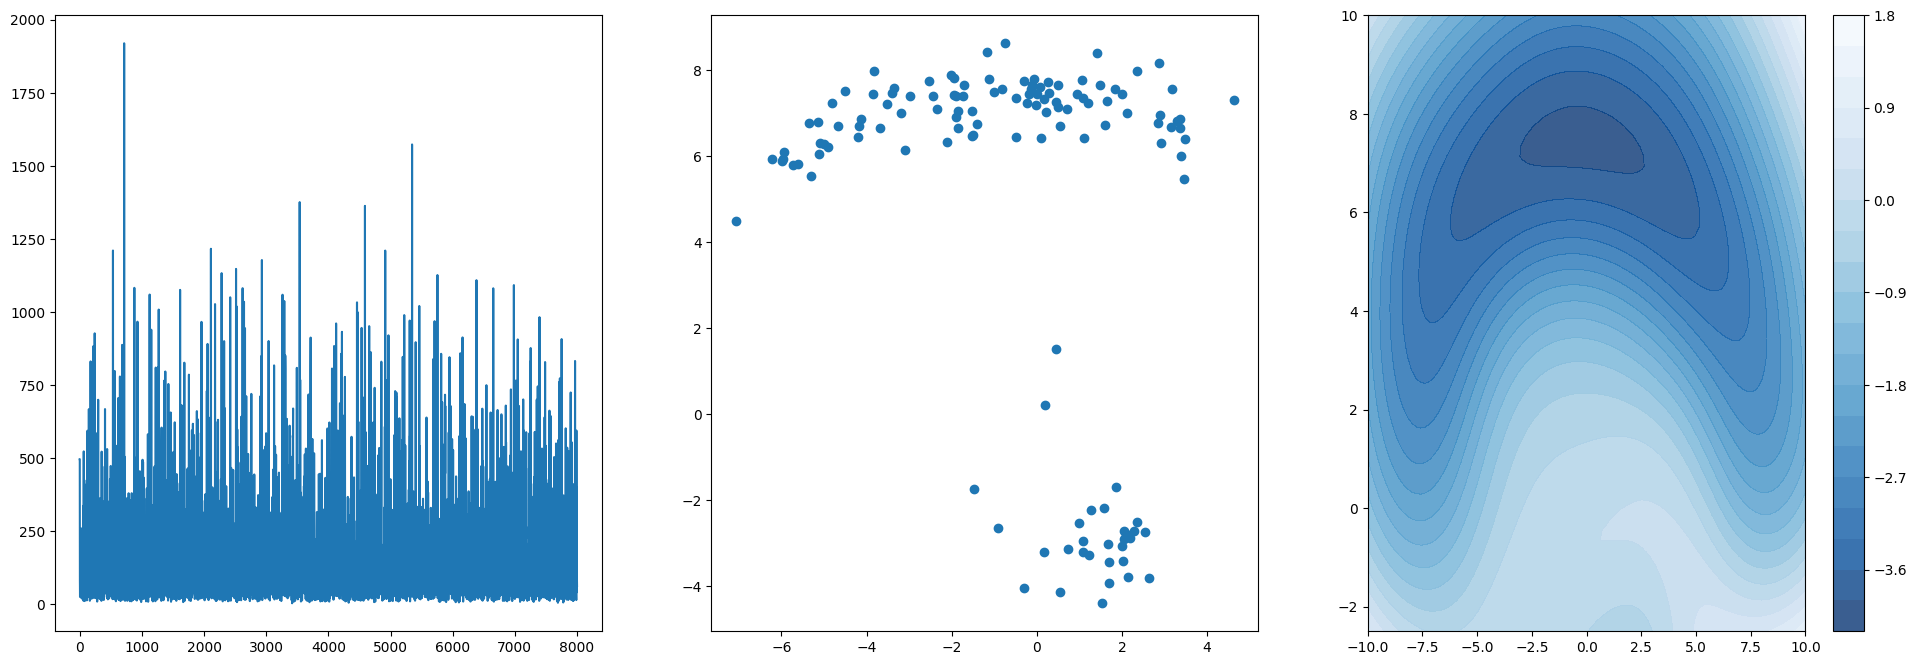

4100 -- loss : 162.987427
4200 -- loss : 260.366852
4300 -- loss : 112.084366
4400 -- loss : 90.393814
4500 -- loss : 72.994987
4600 -- loss : 12.057594
4700 -- loss : 26.325033
4800 -- loss : 223.839859
4900 -- loss : 131.073837
5000 -- loss : 240.800140


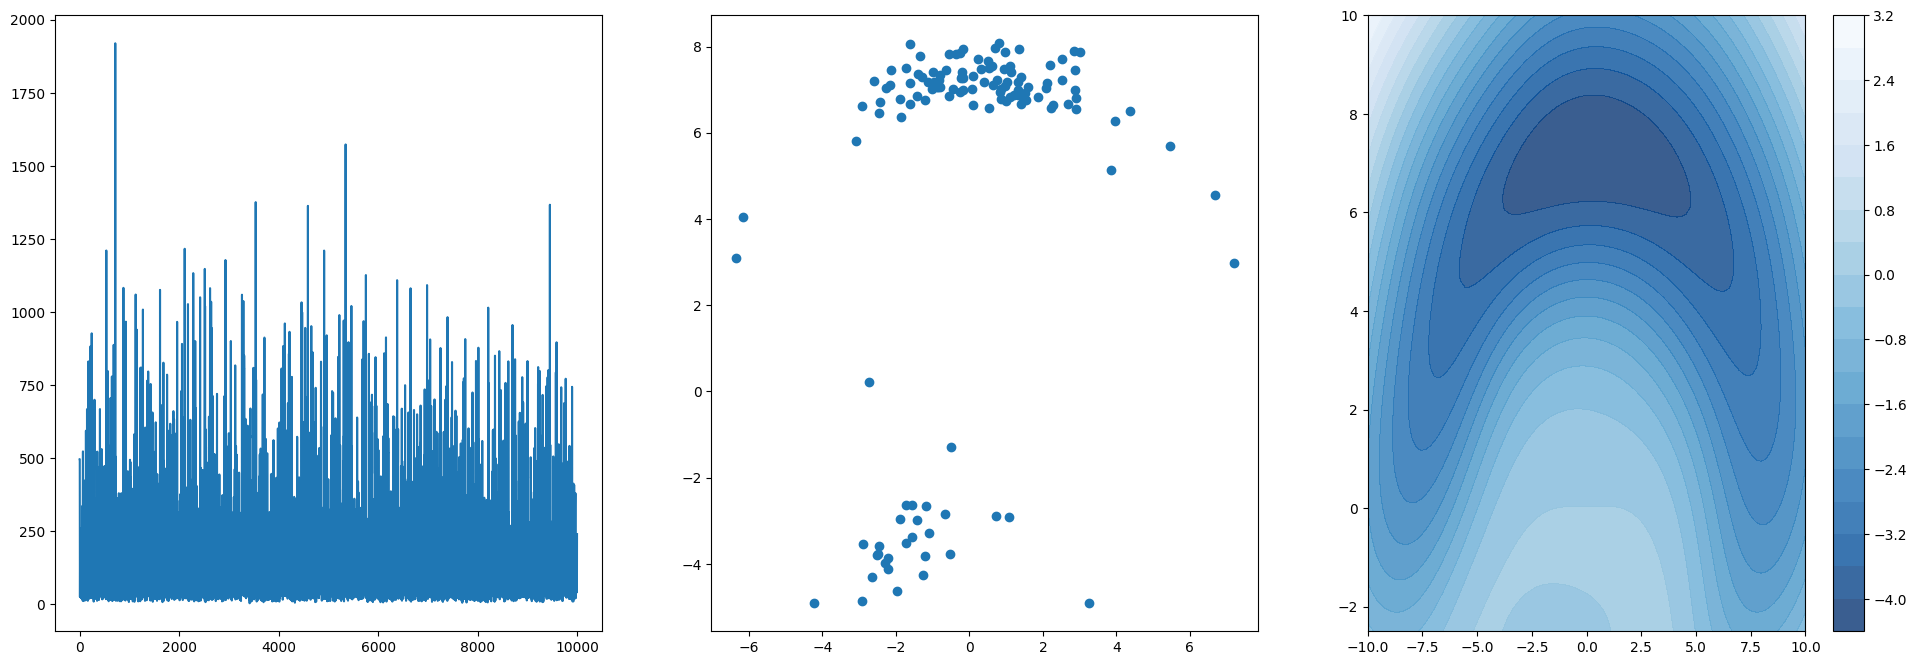

5100 -- loss : 124.949692
5200 -- loss : 78.273254
5300 -- loss : 471.235168
5400 -- loss : 38.113354
5500 -- loss : 238.804901
5600 -- loss : 121.511292
5700 -- loss : 30.175749
5800 -- loss : 204.518555
5900 -- loss : 511.062958
6000 -- loss : 518.576050


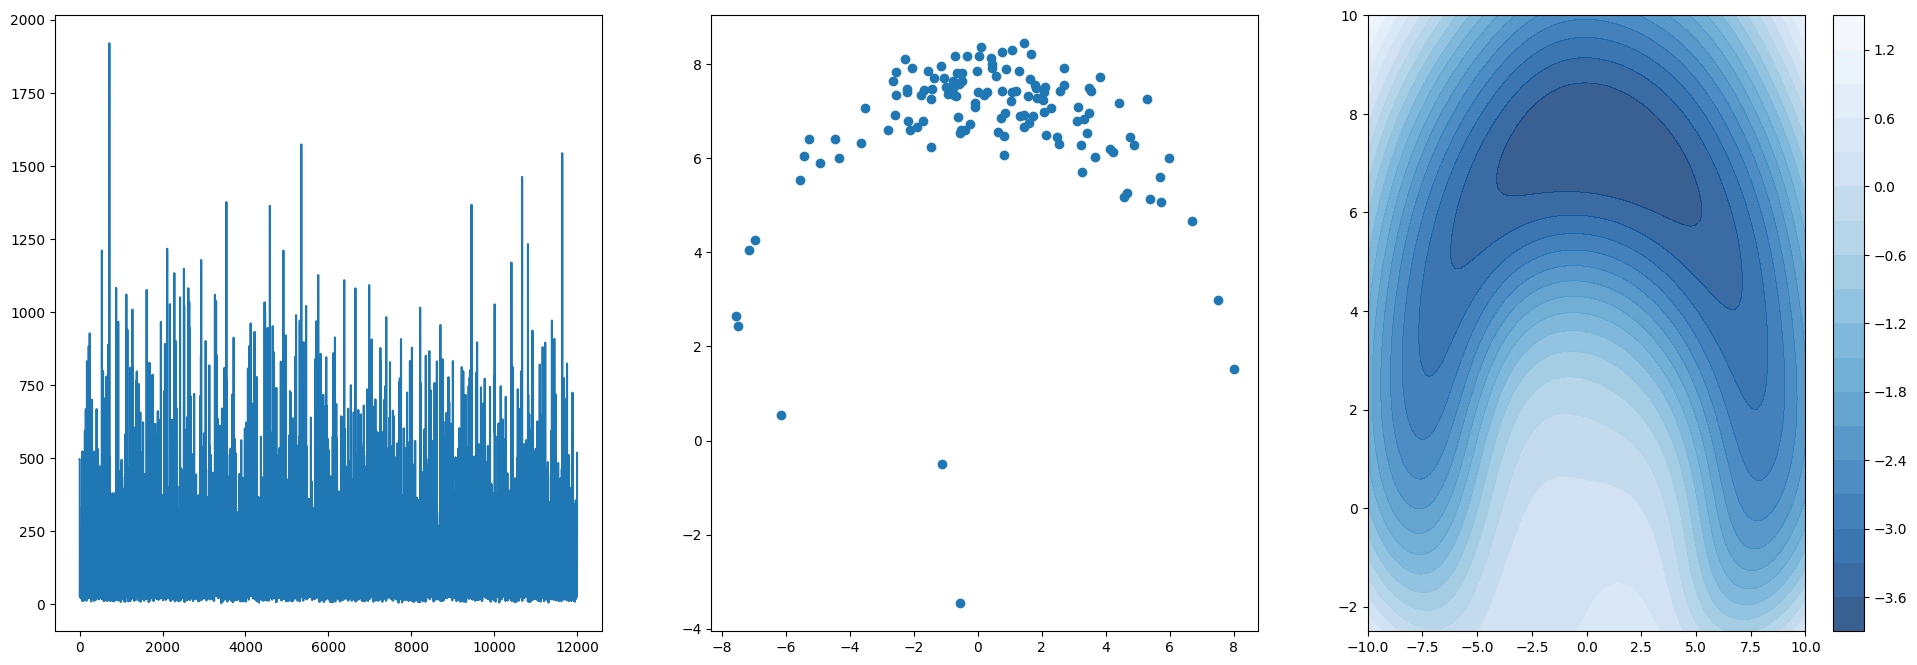

6100 -- loss : 43.618103
6200 -- loss : 109.139725
6300 -- loss : 46.818352
6400 -- loss : 65.517021
6500 -- loss : 322.086670
6600 -- loss : 83.842667
6700 -- loss : 16.261284
6800 -- loss : 131.949936
6900 -- loss : 40.980022
7000 -- loss : 223.093811


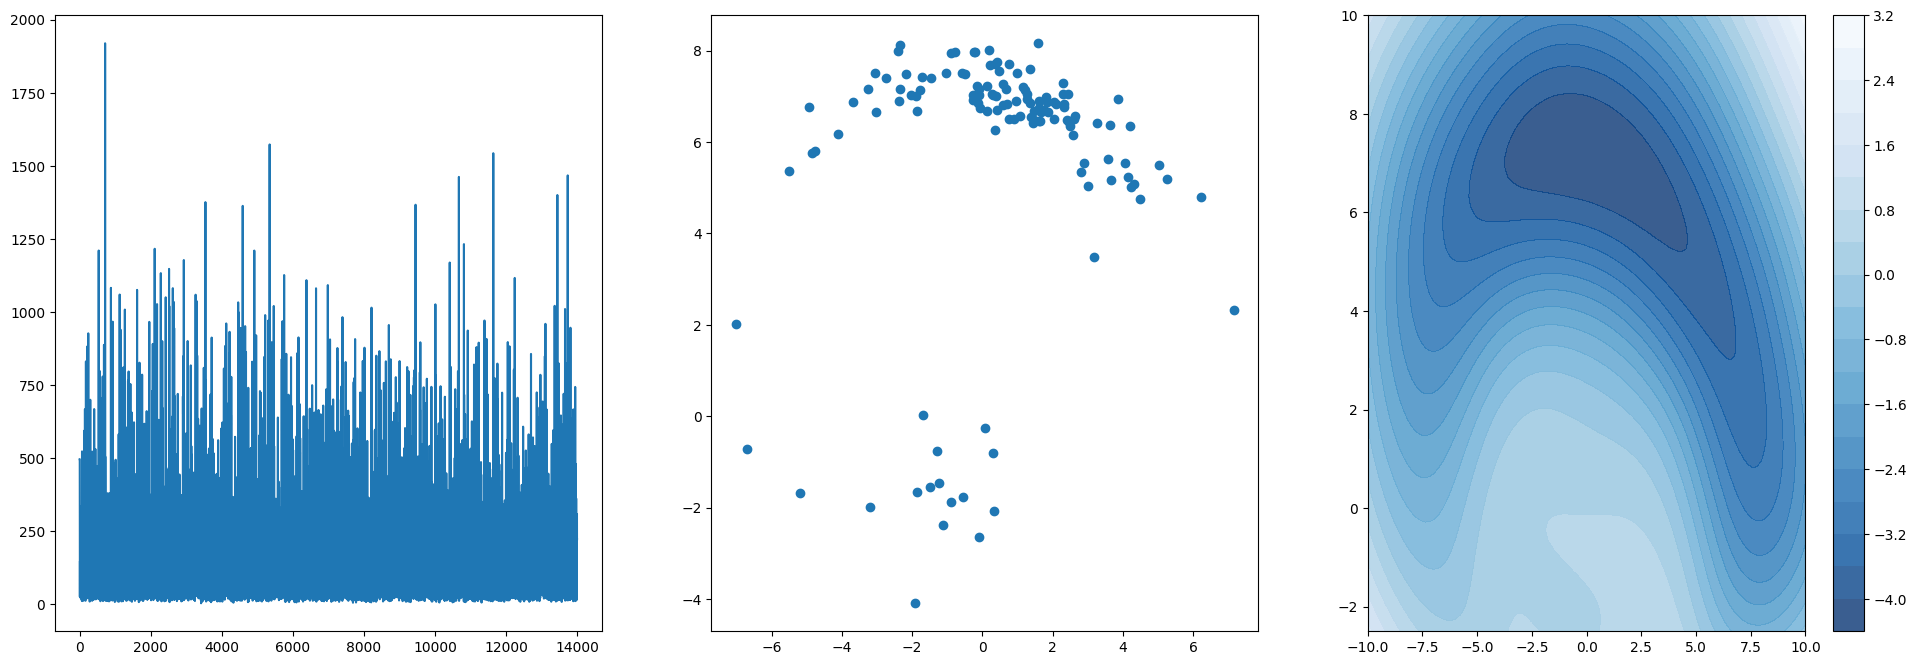

7100 -- loss : 69.423294
7200 -- loss : 33.536934
7300 -- loss : 111.128822
7400 -- loss : 55.635887
7500 -- loss : 103.955994
7600 -- loss : 103.499557
7700 -- loss : 437.520538
7800 -- loss : 49.020813
7900 -- loss : 664.235901
8000 -- loss : 462.430389


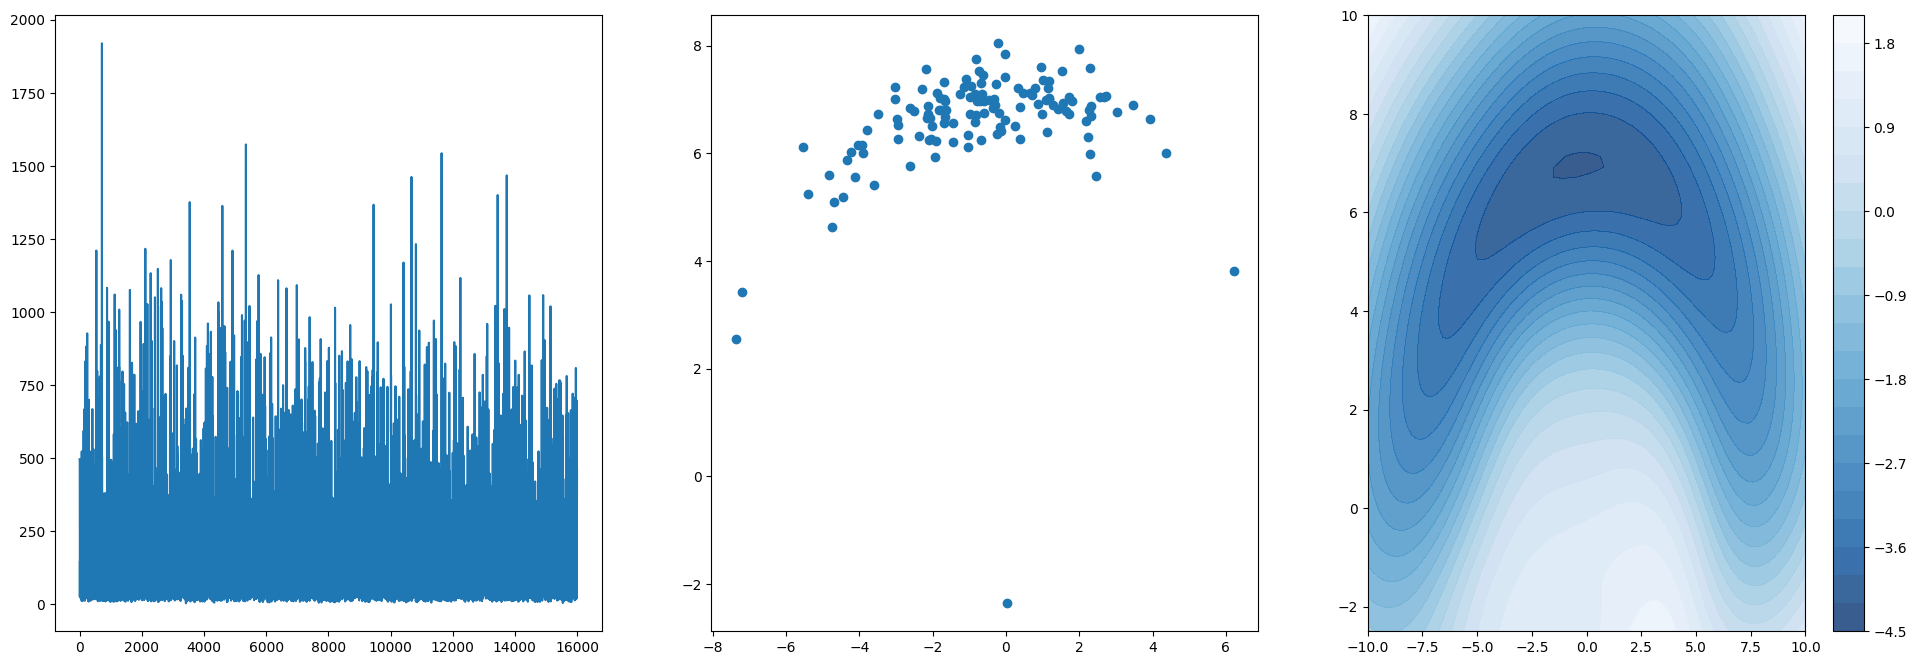

8100 -- loss : 59.357025
8200 -- loss : 14.427105
8300 -- loss : 48.915874
8400 -- loss : 128.784317
8500 -- loss : 297.264313
8600 -- loss : 77.523254
8700 -- loss : 26.448692
8800 -- loss : 317.141754
8900 -- loss : 27.890575
9000 -- loss : 15.210442


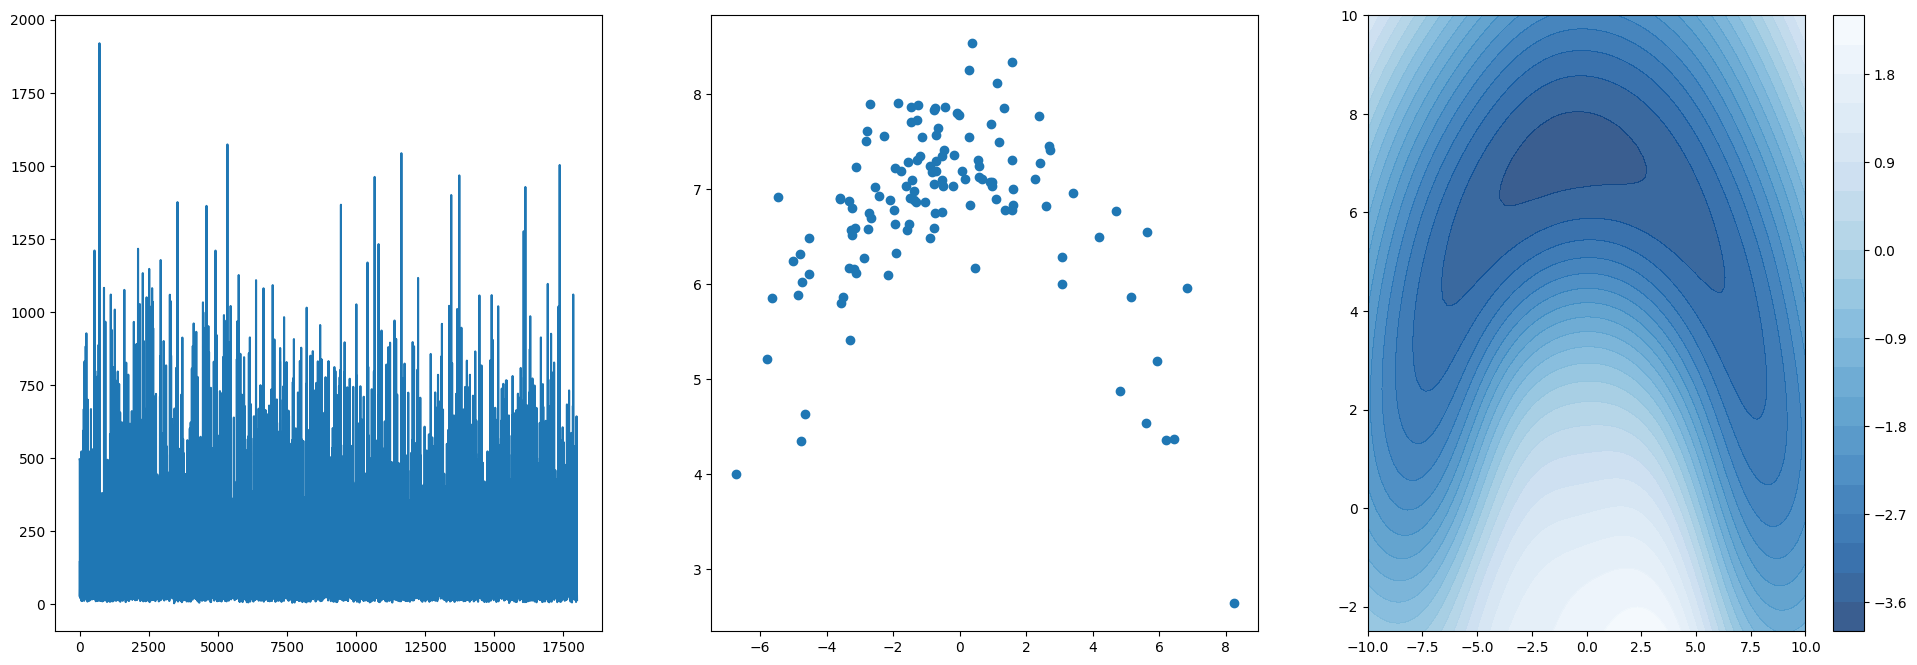

9100 -- loss : 320.907654
9200 -- loss : 69.228348
9300 -- loss : 183.479904
9400 -- loss : 333.011169
9500 -- loss : 29.207264
9600 -- loss : 402.150513
9700 -- loss : 180.918884
9800 -- loss : 27.577698
9900 -- loss : 643.024963
10000 -- loss : 471.414062


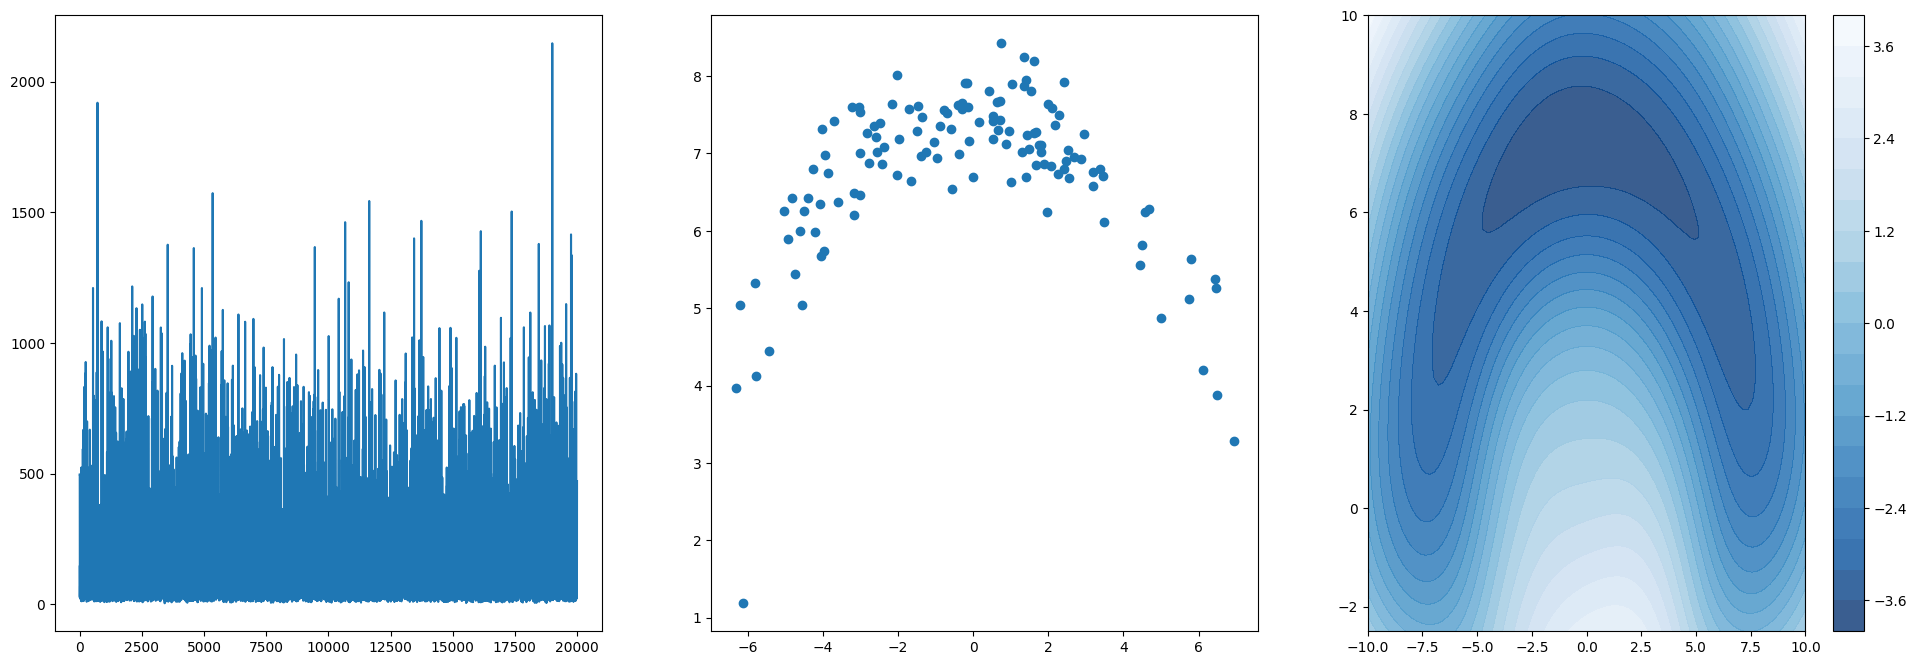

10100 -- loss : 161.794922
10200 -- loss : 42.005371
10300 -- loss : 48.571156
10400 -- loss : 52.590347
10500 -- loss : 70.165375
10600 -- loss : 21.052097
10700 -- loss : 15.128431
10800 -- loss : 286.164978
10900 -- loss : 18.208759
11000 -- loss : 95.118683


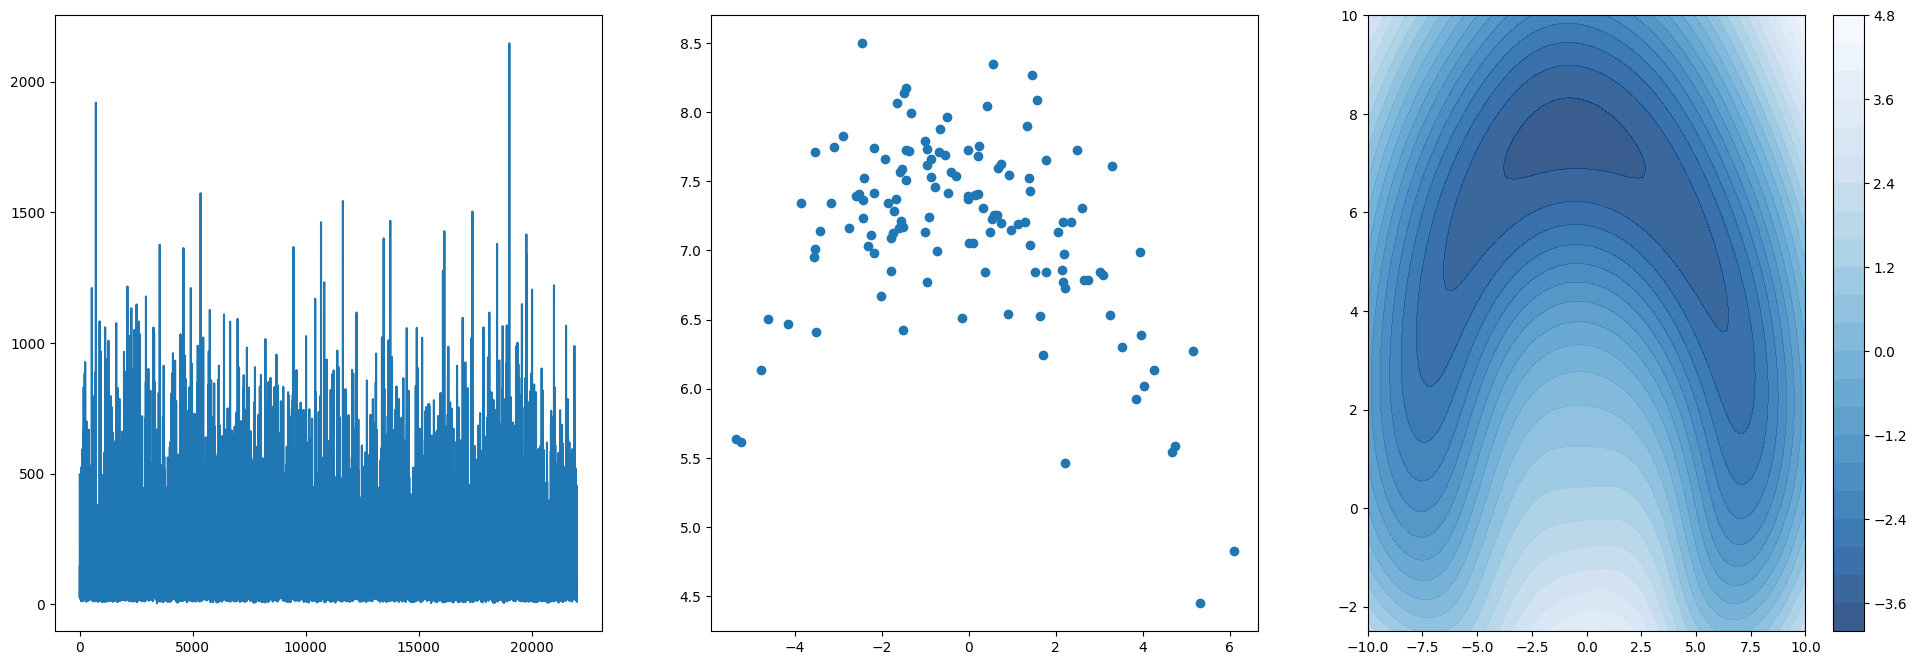

11100 -- loss : 55.081989
11200 -- loss : 84.575928
11300 -- loss : 425.708740
11400 -- loss : 213.376740
11500 -- loss : 199.724884
11600 -- loss : 36.655354
11700 -- loss : 9.948222
11800 -- loss : 150.583374
11900 -- loss : 790.514648
12000 -- loss : 163.385742


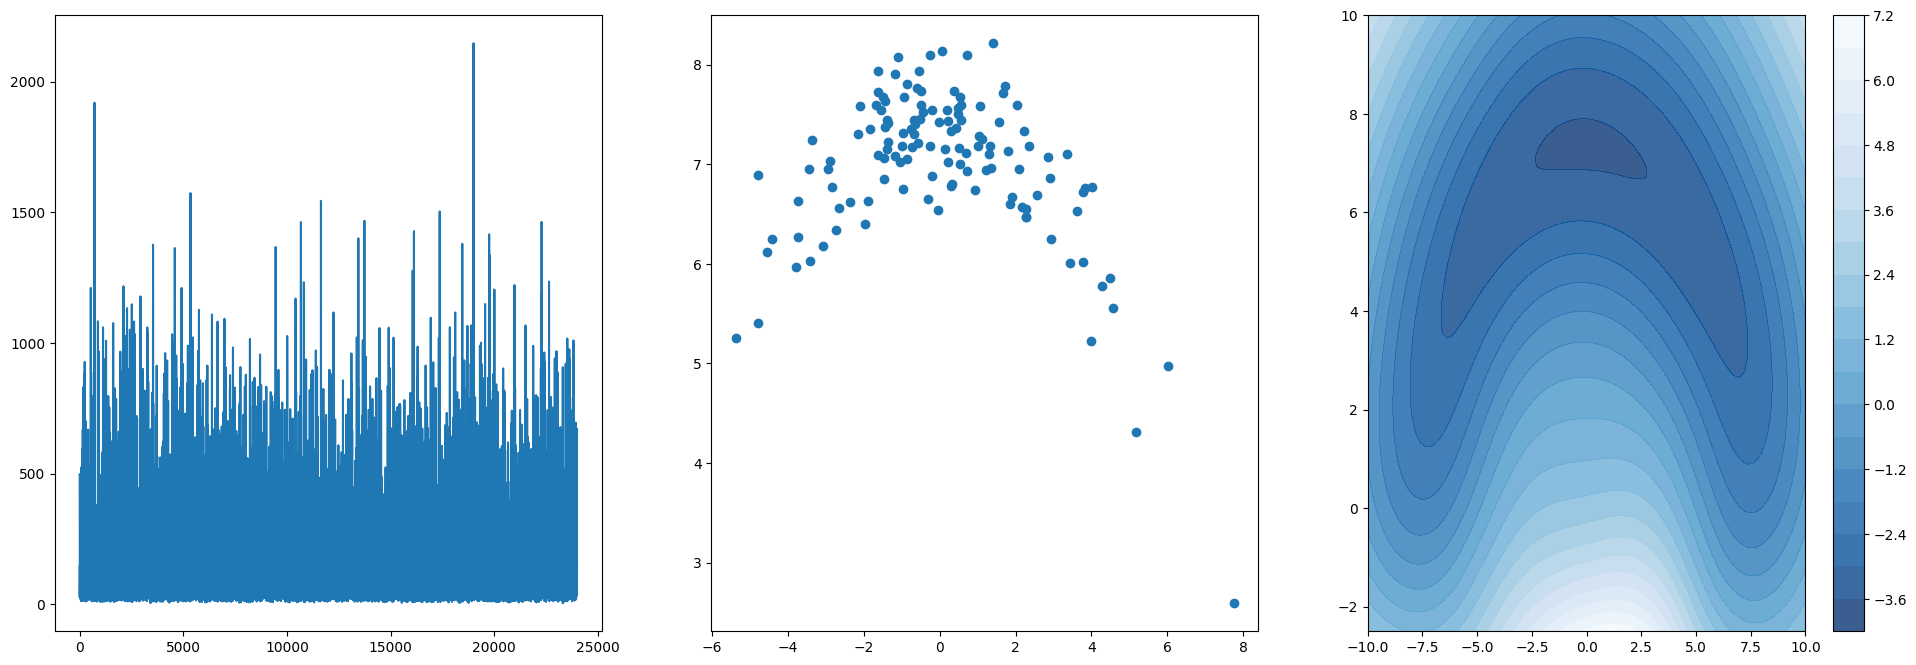

12100 -- loss : 10.615108
12200 -- loss : 125.996628
12300 -- loss : 195.049652
12400 -- loss : 43.263313
12500 -- loss : 13.632443
12600 -- loss : 18.273249
12700 -- loss : 18.202181
12800 -- loss : 35.264500
12900 -- loss : 275.985596
13000 -- loss : 438.461761


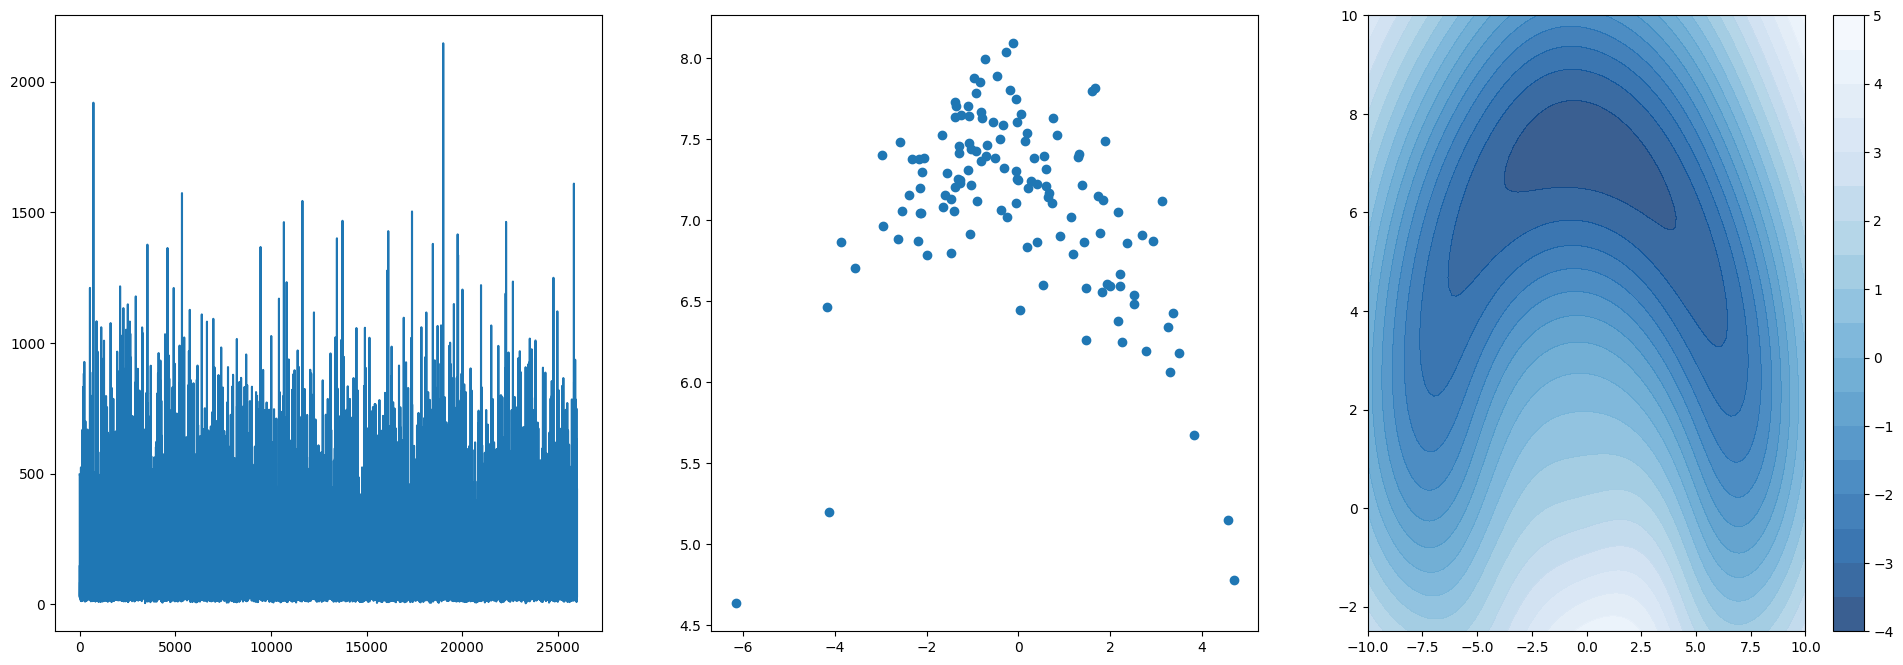

13100 -- loss : 94.637093
13200 -- loss : 248.089035
13300 -- loss : 28.742256
13400 -- loss : 110.767914
13500 -- loss : 101.735947
13600 -- loss : 644.881836
13700 -- loss : 39.777233
13800 -- loss : 108.144196
13900 -- loss : 205.951324
14000 -- loss : 50.647827


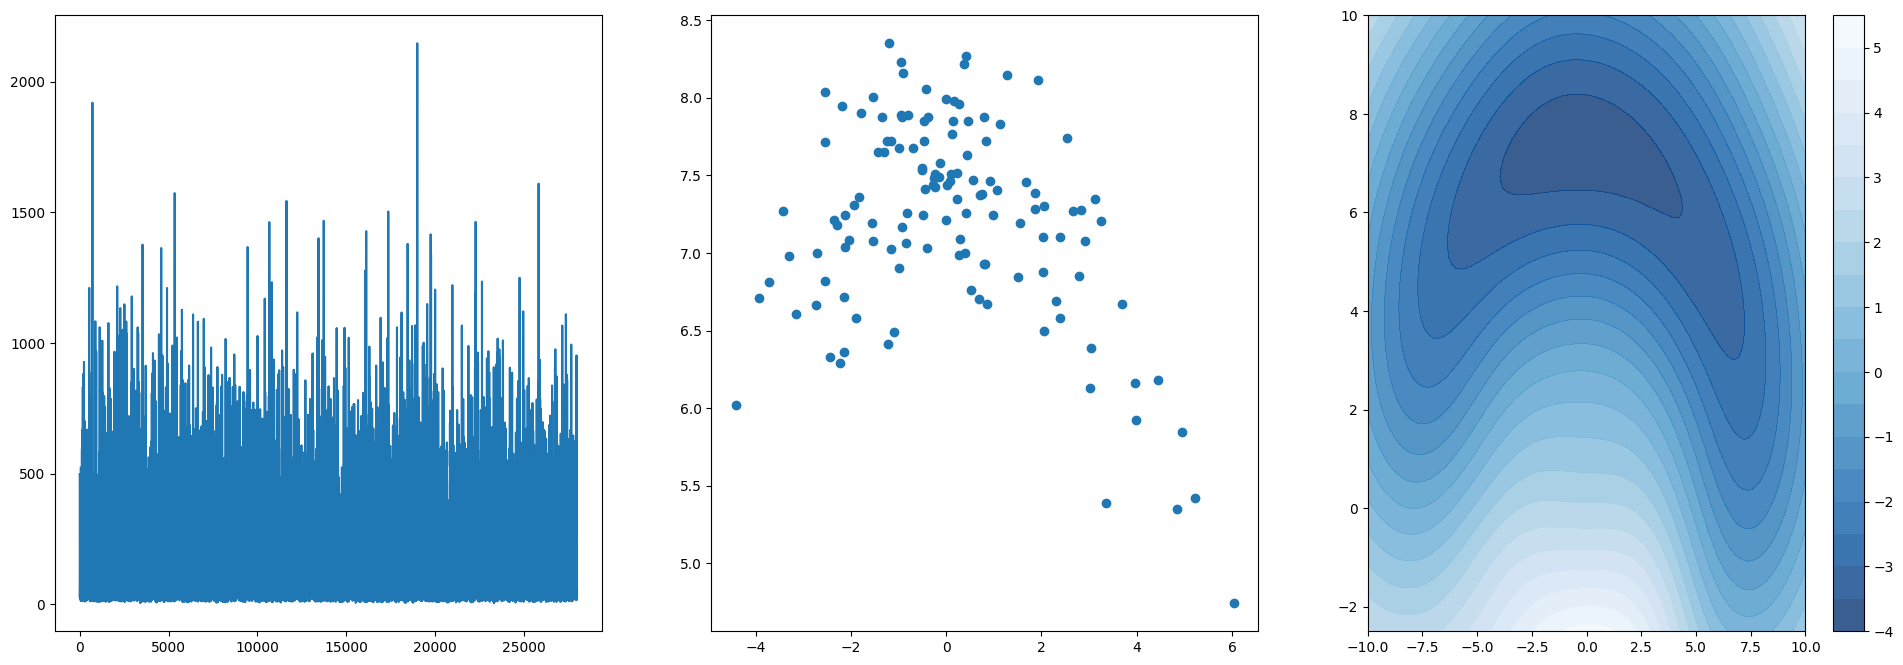

14100 -- loss : 350.463715
14200 -- loss : 181.379486
14300 -- loss : 341.832428
14400 -- loss : 32.271767
14500 -- loss : 481.333252
14600 -- loss : 656.893555
14700 -- loss : 21.468573
14800 -- loss : 33.542358
14900 -- loss : 861.841431
15000 -- loss : 236.837479


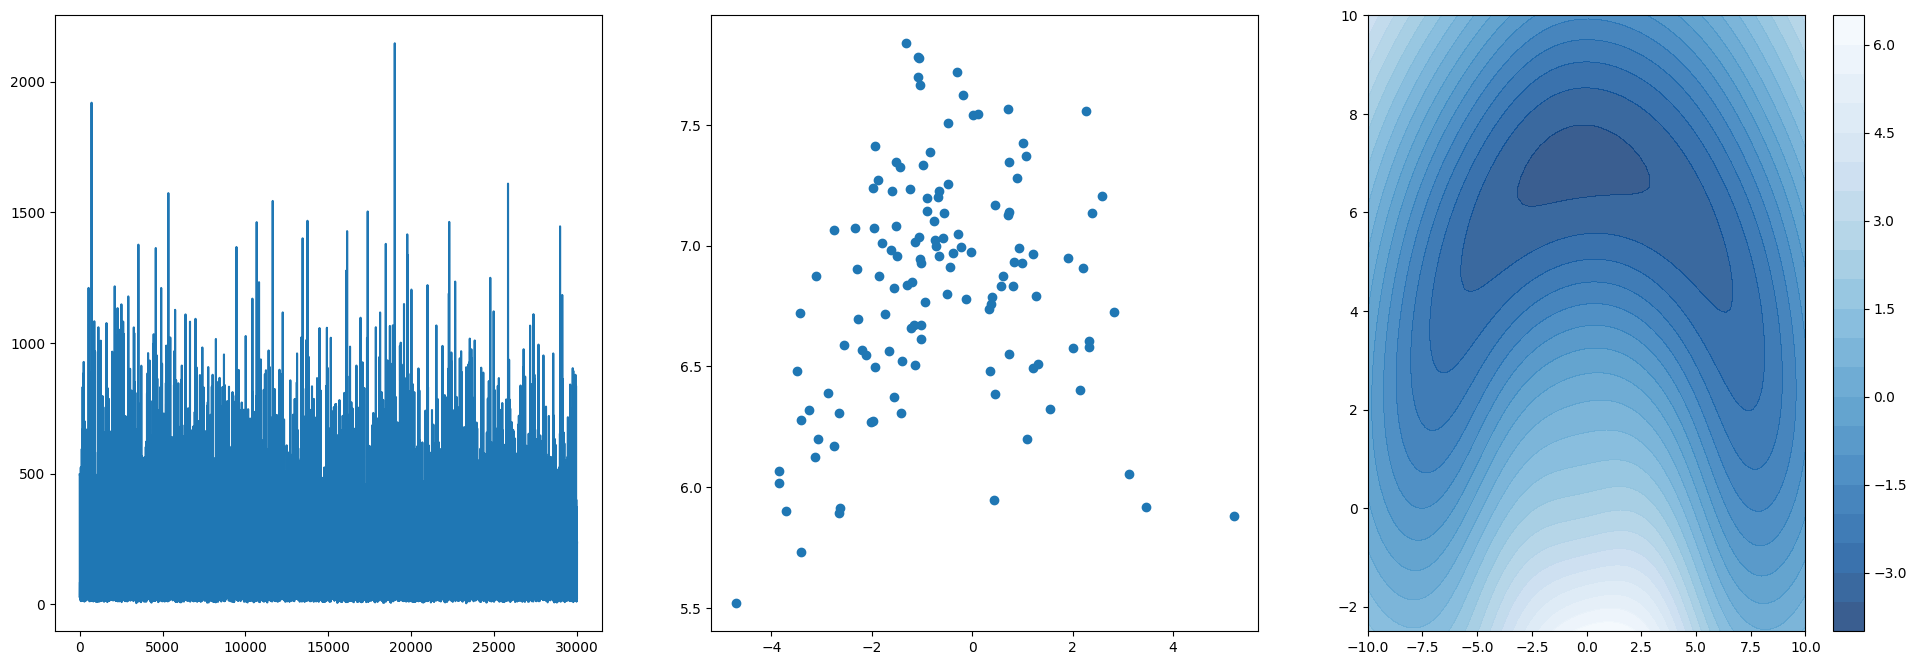

15100 -- loss : 47.006409
15200 -- loss : 234.118195
15300 -- loss : 16.751534
15400 -- loss : 93.812820
15500 -- loss : 36.740314
15600 -- loss : 33.039883
15700 -- loss : 77.287323
15800 -- loss : 179.401443
15900 -- loss : 22.474989
16000 -- loss : 227.283737


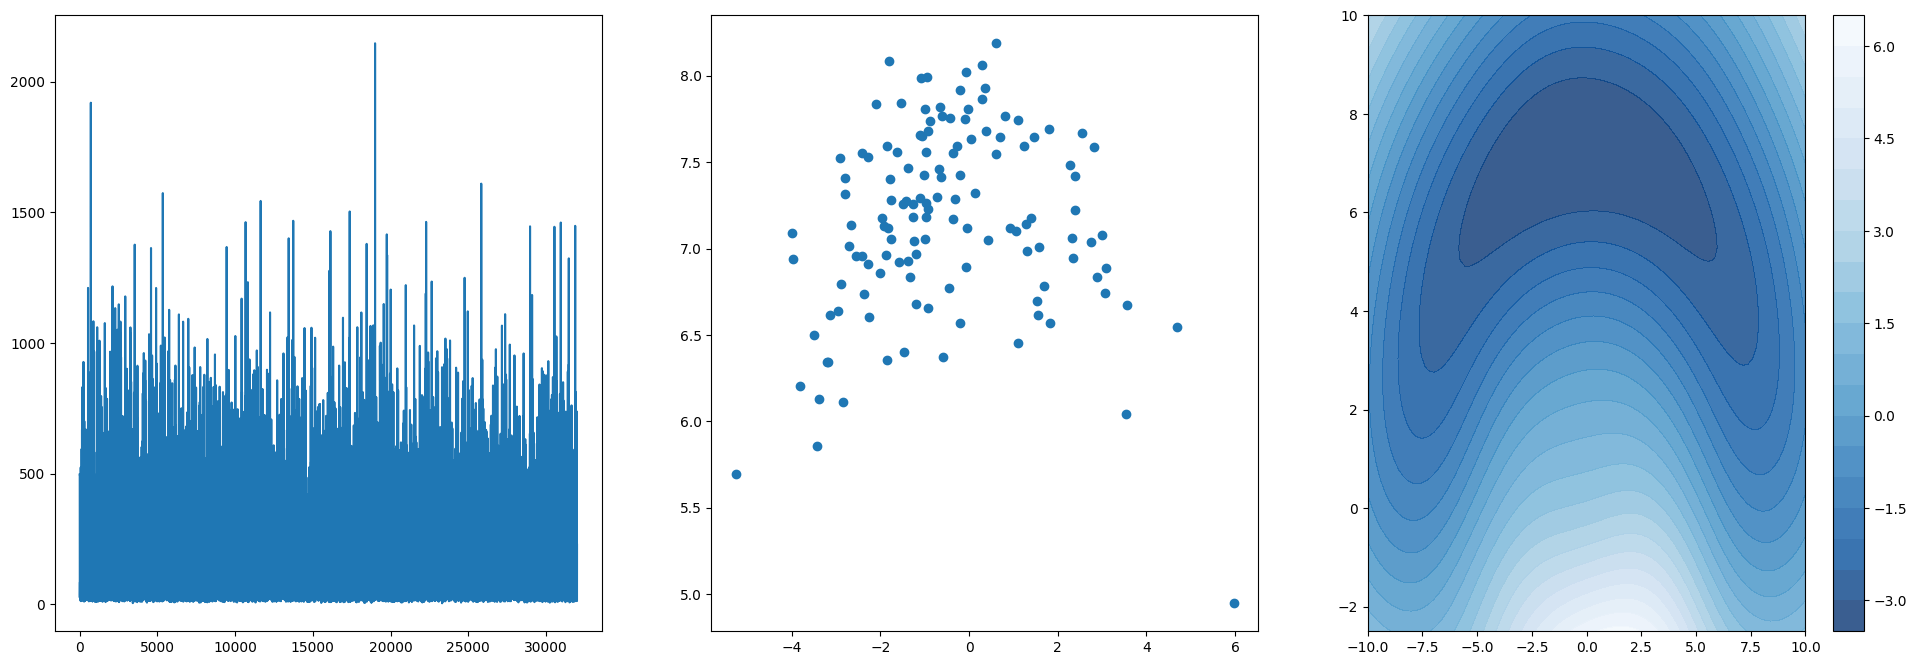

16100 -- loss : 143.933868
16200 -- loss : 36.032516
16300 -- loss : 106.831055
16400 -- loss : 142.350571
16500 -- loss : 255.677444
16600 -- loss : 200.268433
16700 -- loss : 71.429321
16800 -- loss : 80.574043
16900 -- loss : 324.353333
17000 -- loss : 106.314224


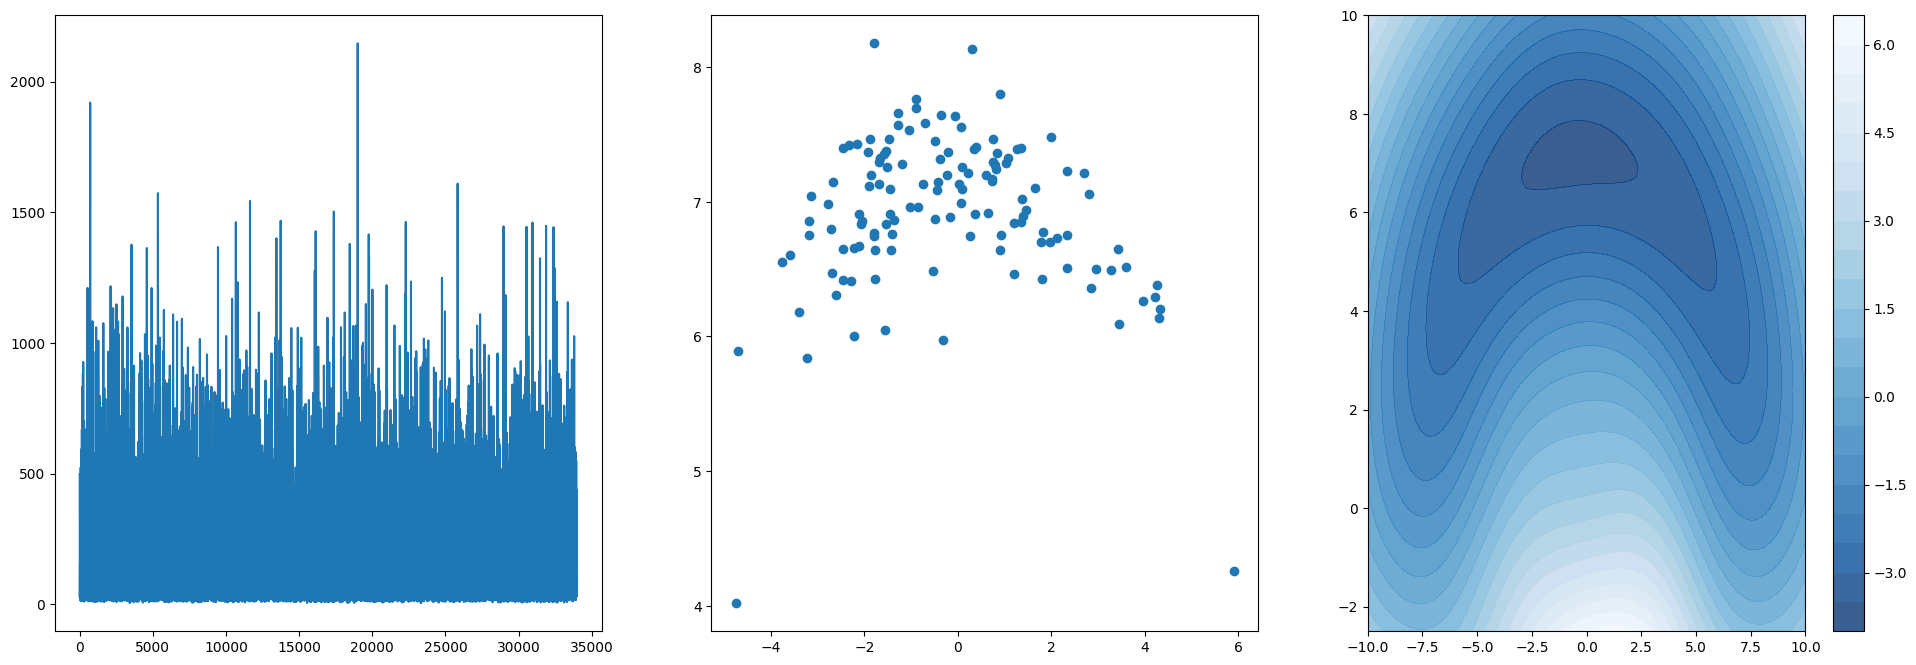

17100 -- loss : 43.602539
17200 -- loss : 66.076561
17300 -- loss : 136.104782
17400 -- loss : 9.336567
17500 -- loss : 296.189728
17600 -- loss : 407.884705
17700 -- loss : 18.293459
17800 -- loss : 59.877872
17900 -- loss : 56.603706
18000 -- loss : 881.281738


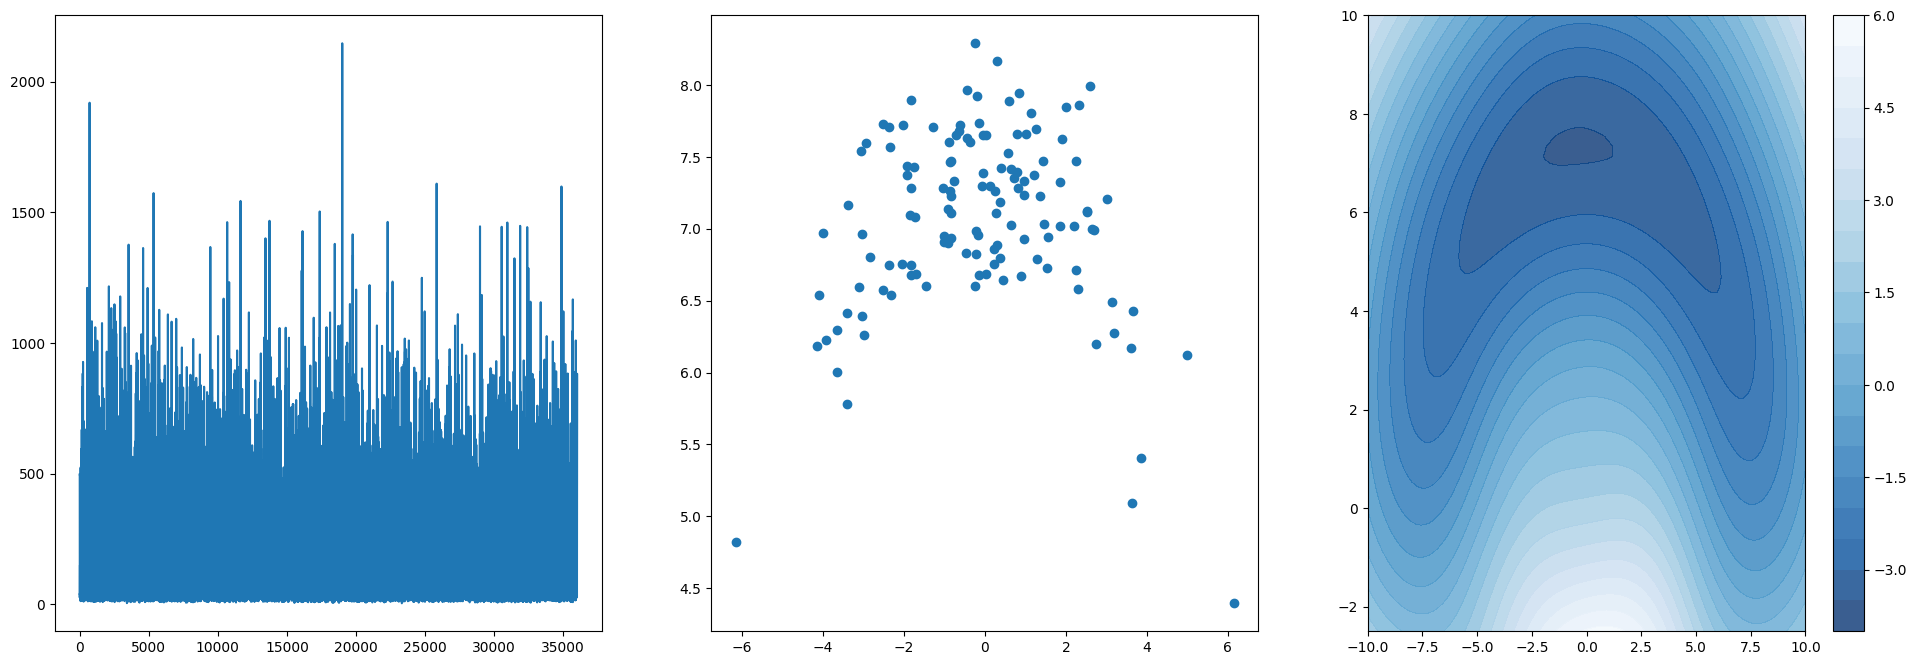

18100 -- loss : 42.778416
18200 -- loss : 15.924438
18300 -- loss : 81.900887
18400 -- loss : 277.038940
18500 -- loss : 122.878174
18600 -- loss : 150.722794
18700 -- loss : 21.244606
18800 -- loss : 253.665207
18900 -- loss : 50.291290
19000 -- loss : 44.448814


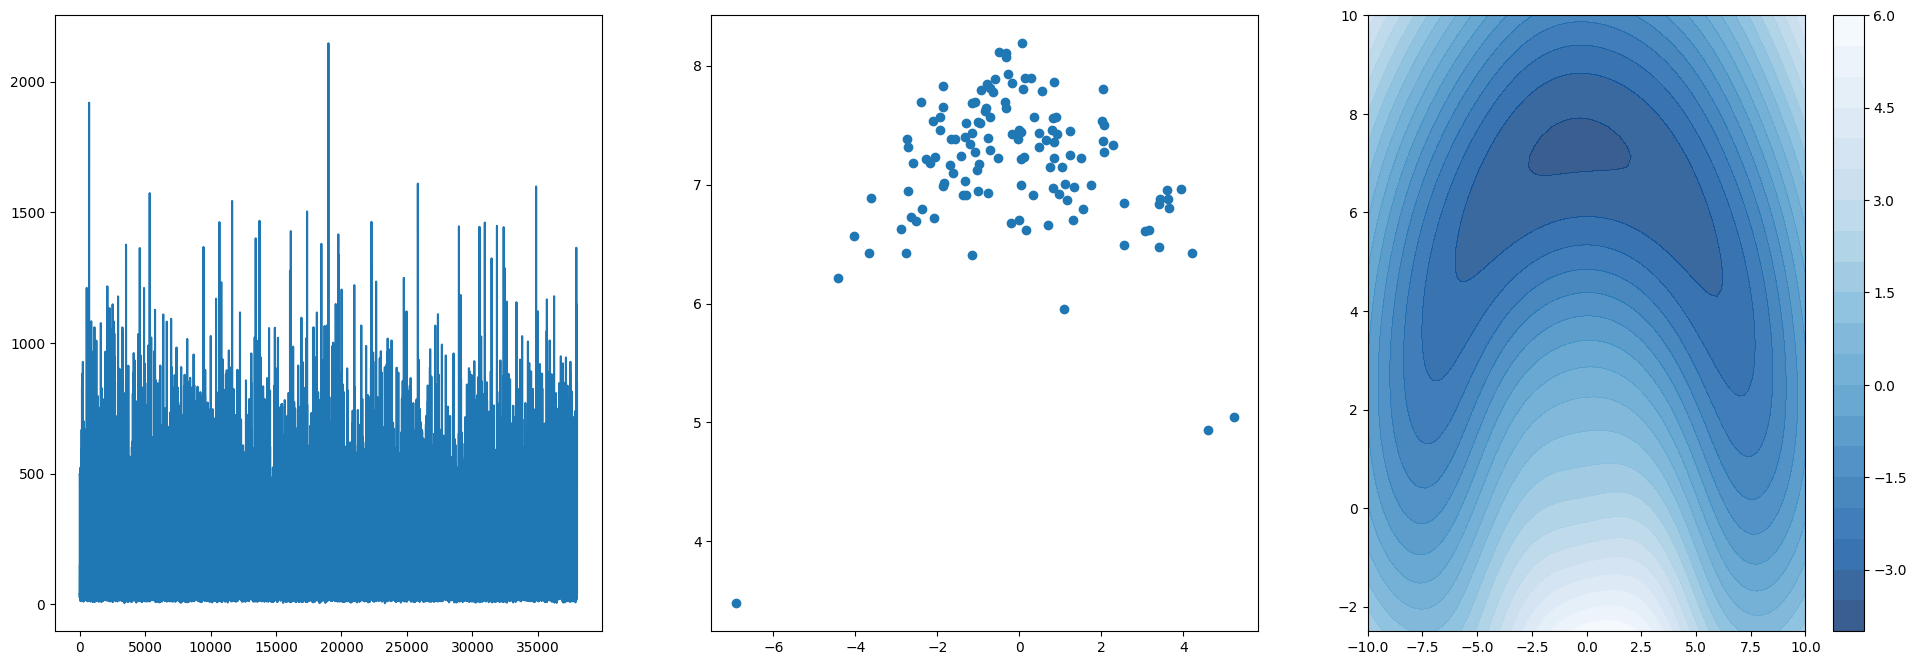

19100 -- loss : 341.374908
19200 -- loss : 188.408234
19300 -- loss : 172.804474
19400 -- loss : 21.416922
19500 -- loss : 22.123379
19600 -- loss : 294.575256
19700 -- loss : 200.680817
19800 -- loss : 404.438141
19900 -- loss : 80.861839


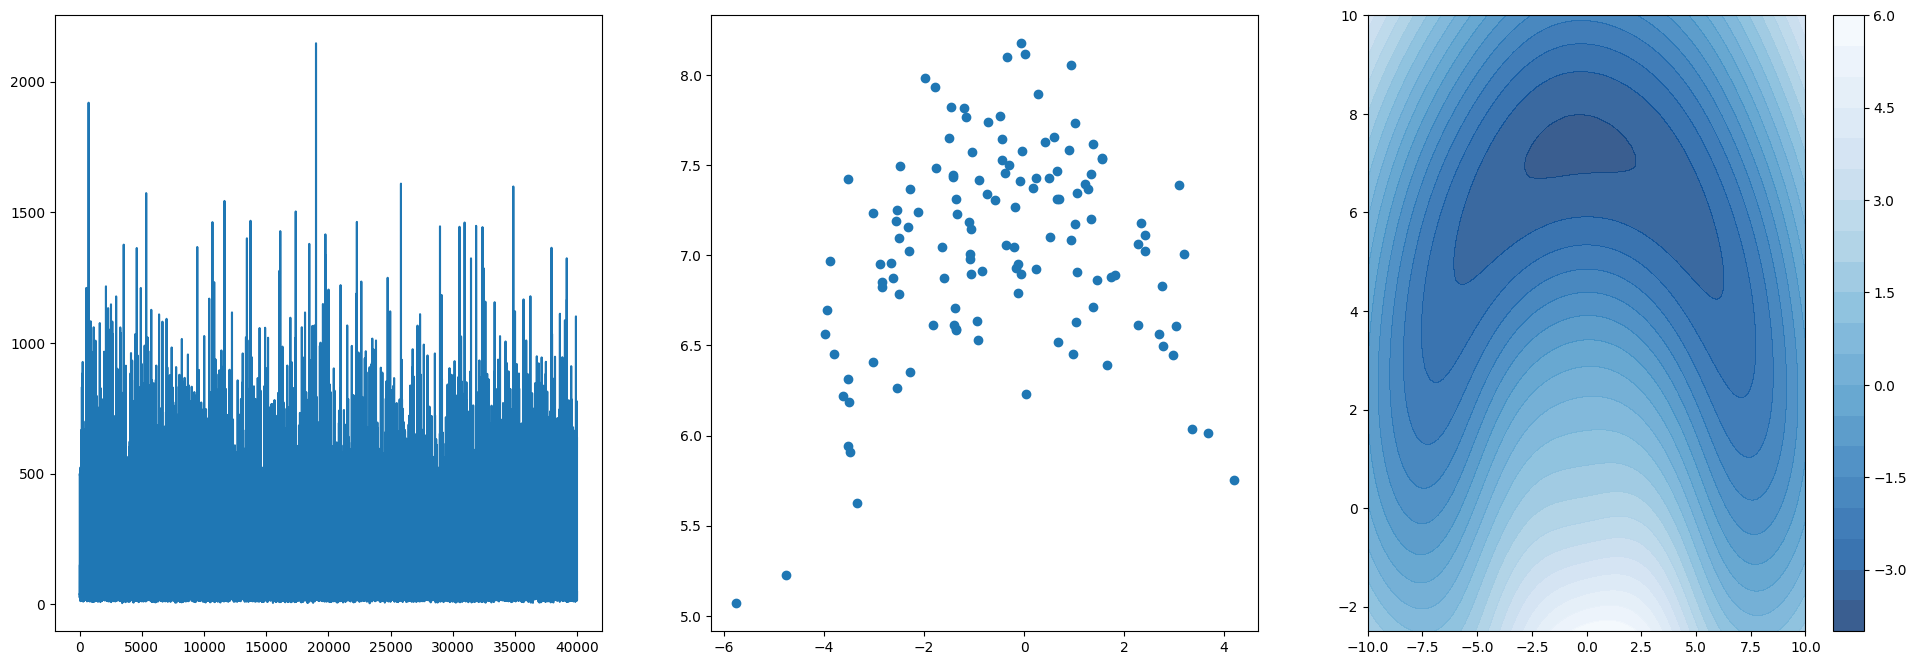

In [6]:
## Network 
SGLD_STEPS = 1000
SGLD_STD = 1e-1
SGLD_LR = 0.05
EPOCH = 20000
BATCH_SIZE = 128
netE = MLP_ELU_convex().to(DEVICE)
en = lambda x: netE(x) 

train_EBM=True
if train_EBM:
    optimizer = torch.optim.Adam(netE.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, EPOCH, eta_min=1e-6)
    all_loss = []
    for i in range(EPOCH):
        optimizer.zero_grad()
        x = mixture_2.sample(BATCH_SIZE)
        
        sigma = (torch.randint(1,200, (BATCH_SIZE,)).float()/100.0).unsqueeze(1).to(DEVICE)
        x_noisy = x + torch.randn_like(x) * sigma
        x_noisy.requires_grad_(True)
        score_estimate = -torch.autograd.grad(en(x_noisy).sum(), x_noisy, create_graph=True)[0]
        score_target = -(x_noisy - x) / sigma**2

        
        loss = ((score_estimate - score_target)**2).sum(dim=1).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        all_loss.append(loss.item())

        
        all_loss.append(loss.item())
        if i % 100 ==0 :
            print(f"{i} -- loss : {loss.item():0.6f}")
        if i % 1000 == 0 or i == EPOCH-1:
        
            x_i = torch.randn_like(x)
            x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
            all_e = en(pos)
            fig, ax = plt.subplots(1, 3, figsize=(3*8,8))
            ax[0].plot(all_loss)
            ax[1].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
            im = ax[2].contourf(x_p, y_p, all_e.view(62,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
            fig.colorbar(im, ax=ax[2])
            plt.show()
    to_save = {"weight": netE.state_dict(),
               "type": type(netE)}
    torch.save(to_save, f"./EBM_mixture2.pth")
else:
    ckpt = torch.load(f"./EBM_mixture2.pth", weights_only=False)
    netE.load_state_dict(ckpt["weight"], strict=True)
    en = lambda x: netE(x)
    x_i = torch.randn(BATCH_SIZE, 2).to(DEVICE)
    x_s = sgld(en, x_i, n_steps=SGLD_STEPS, sgld_std=SGLD_STD, sgld_lr=SGLD_LR)
    #x_p, y_p = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(-5, 5, 100), indexing='xy')
    #pos = torch.cat([x_p.flatten().unsqueeze(1), y_p.flatten().unsqueeze(1)], dim=1).to(DEVICE)
    all_e = en(pos)
    fig, ax = plt.subplots(1, 2, figsize=(2*8,8))
    ax[0].scatter(x_s[:,0].cpu().detach(), x_s[:,1].cpu().detach())
    im = ax[1].contourf(x_p, y_p, all_e.view(62,100).detach().cpu(), 20, cmap='Blues_r', alpha=0.8, zorder=0, levels=20)
    fig.colorbar(im, ax=ax[1])
    plt.show()
    